In [2]:
'''libraries list with help showing the version of the libraries being used in this nodebook'''
libraries = []

'''Datasets, arrays and files '''
import pandas as pd
import numpy as np
import pickle
libraries.append('pandas')
libraries.append('numpy')
libraries.append('pickle')

'''Following progress'''
from tqdm.notebook import tqdm
libraries.append('tqdm')

'''Plots'''
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpldatacursor import datacursor
from mpldatacursor import HighlightingDataCursor
import seaborn as sns
plt.style.use('seaborn-paper')
plt.rcParams["figure.facecolor"] = "w"

libraries.append('matplotlib')
libraries.append('mpldatacursor')
libraries.append('seaborn')
                 
'''Networks and community detection'''
import networkx as nx
import igraph as ig
import community as community_louvain
from networkx.algorithms import community
from sklearn import cluster
libraries.append('networkx')
libraries.append('igraph')

'''Measures and utilities'''
from Levenshtein import distance
import statistics
from sklearn.metrics import normalized_mutual_info_score 
from sklearn.metrics.cluster import adjusted_rand_score
from collections import defaultdict
import math
from statistics import mean, stdev
from operator import truediv

libraries.append('collections')
libraries.append('scikit-learn')
libraries.append('math')
libraries.append('statistics')

'''Pthon and library version'''
import types
import pkg_resources
import sys
from platform import python_version

In [3]:
'''To display version of Software being used'''
print('Version of python installed: {}' .format(sys.version))
print('Version of python being used: {}' .format(python_version()))
print('\nNon-built in libraries being used:')

for m in pkg_resources.working_set:
    if m.project_name.lower() in libraries:
        print('{}, version {}'.format(m.project_name,m.version))

Version of python installed: 3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
Version of python being used: 3.8.10

Non-built in libraries being used:
tqdm, version 4.62.3
seaborn, version 0.11.2
scikit-learn, version 0.22.1
pandas, version 1.3.3
numpy, version 1.19.2
networkx, version 2.6.3
mpldatacursor, version 0.7.1
matplotlib, version 3.4.3


In [4]:
def total_weight_attribute(G):
    '''It returns the total of the weight attributes in a given network G'''
    edges = list(G.edges(data=True))
    total_weight = 0
    for e in tqdm(range(len(edges))):
        total_weight += edges[e][2]['weight']
    return total_weight

def expectation_sharing_edge(G, node1, node2, L):
    '''Returns a float indicating the proportion of expected weight or co-ocurrences
    between two hashtags in a network'''
    #print(node1, node2)
    p = (G.degree[node1]*G.degree[node2])/(2*L)
    return p

def normalize_weights(G, weighted_edges):
    '''Given a graph G and a list of weighted edges in the way:
    weighted_edges = [('corona', 'TBT', 1), ('corona', 'newnormal', 4), ... ]
    it returns normalized weights n_weighted_edges in the same structure
    '''
    total_p = []
    n_weighted_edges = []
    total_w = []
    L = nx.number_of_edges(G)
    i = 0
    for node1, node2, weight in tqdm(weighted_edges):
        p = expectation_sharing_edge(G, node1, node2, L)
        n_weight =  weight/p  
        if i < 10:
            print('n1:', node1,' n2:', node2, ' p:',p,' w:',weight , 'n_w:',n_weight)
        total_p.append(p)
        total_w.append(n_weight)
        tup = (node1, node2, n_weight)
        n_weighted_edges.append(tup)
        i += 1
    
    w_min = min(total_w)
    w_max = max(total_w)
    print('Sum p: ',sum(total_p), ' min: ', w_min, ' max:', w_max)
    nn_weighted_edges = []
    #Normalize in the range between 0-1
    for n1, n2, w in n_weighted_edges:
        norm_weight = (w - w_min)/(w_max-w_min)
        tup = (n1, n2, norm_weight)
        nn_weighted_edges.append(tup)
    return nn_weighted_edges

def add_similarity_attr(G):
    '''Given a network G, it will calculate the Levenshtein distance between each pair of nodes
    that share an edge in the network. It will add the distances as an attribute called 
    similarity'''
    attr = {}
    for e1, e2 in G.edges():
        d = distance(e1, e2)
        attr[(e1,e2)] = {'similarity':d}
    nx.set_edge_attributes(G, attr)

def add_correlation_attr(G):
    '''Given a network G, it will calculate the Levenshtein distance between each pair of nodes
    that share an edge in the network. It will add the distances as an attribute called 
    similarity'''
    
    '''To add correlation attribute'''
    file_name = "../_generated_data/edges_corr.pkl"
    open_file = open(file_name, "rb")
    corr_dict = pickle.load(open_file)
    open_file.close()
    attr = {}
    for e1, e2 in tqdm(G.edges()):
        try:
            c = corr_dict[(e1,e2)]
        except KeyError:
            c = corr_dict[(e2,e1)]
        attr[(e1,e2)] = {'correlation':c}
    nx.set_edge_attributes(G, attr)

In [5]:
'''To open the information of weighted edges'''
file_name = "../_generated_data/edges_counts.pkl"
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print('''The hashtags {} and {} have the maximum number of co-occurrences: {}.'''
      .format(max(loaded_list,key=lambda item:item[2])[0],
        max(loaded_list,key=lambda item:item[2])[1],
        max(loaded_list,key=lambda item:item[2])[2])) #Maximum weight

The hashtags Coronavirus and SaveTheWorld have the maximum number of co-occurrences: 2308.


In [6]:
G = nx.Graph()  
G.add_weighted_edges_from(loaded_list)
print('Size: ', G.size())
print('Number of nodes: ', G.number_of_nodes())

Size:  19180
Number of nodes:  518


In [7]:
nx.transitivity(G)

0.3728978094137729

In [8]:
list(G.edges(data=True))[:5]

[('corona', 'TBT', {'weight': 1}),
 ('corona', 'newnormal', {'weight': 4}),
 ('corona', 'quarantine', {'weight': 379}),
 ('corona', 'coronavirus', {'weight': 600}),
 ('corona', 'covid_19', {'weight': 316})]

# Normalize weights

In [9]:
edges_list = list(G.edges(data=True))
node_1 = edges_list[1][0]
node_2 = edges_list[1][1]
edge_weight = edges_list[1][2]['weight']
edge_weight

4

In [10]:
loaded_list[:5]

[('corona', 'TBT', 1),
 ('corona', 'newnormal', 4),
 ('corona', 'quarantine', 379),
 ('corona', 'coronavirus', 600),
 ('corona', 'covid_19', 316)]

In [11]:
normalized_weights= normalize_weights(G, loaded_list)
G = nx.empty_graph()
G.add_weighted_edges_from(normalized_weights)
add_correlation_attr(G)
print('Size: ', G.size())
print('Number of nodes: ', G.number_of_nodes())

  0%|          | 0/19180 [00:00<?, ?it/s]

n1: corona  n2: TBT  p: 0.25351929092805003  w: 1 n_w: 3.9444730077120824
n1: corona  n2: newnormal  p: 1.0140771637122001  w: 4 n_w: 3.9444730077120824
n1: corona  n2: quarantine  p: 4.076590198123045  w: 379 n_w: 92.96985509470642
n1: corona  n2: coronavirus  p: 4.309827945776851  w: 600 n_w: 139.2166943898382
n1: corona  n2: covid_19  p: 3.711522419186653  w: 316 n_w: 85.14026437411324
n1: corona  n2: stayhome  p: 3.4275808133472365  w: 250 n_w: 72.93774052722046
n1: corona  n2: washyourhands  p: 1.2270333680917622  w: 13 n_w: 10.59465890501179
n1: corona  n2: lockdown  p: 2.7075860271115744  w: 69 n_w: 25.483954825106153
n1: corona  n2: black  p: 0.6591501564129302  w: 6 n_w: 9.102630017797113
n1: corona  n2: photography  p: 2.0687174139728883  w: 26 n_w: 12.568173799082615
Sum p:  8109.4242700730365  min:  0.4004426164477942  max: 469910.0


  0%|          | 0/19180 [00:00<?, ?it/s]

Size:  19180
Number of nodes:  518


# Check connected components

In [12]:
len(list(nx.connected_components(G)))

2

In [13]:
'''To keep the largest connected component'''
#G = G.subgraph(max(nx.connected_components(G), key=len))
#print('Size: ', G.size())
#print('Number of nodes: ', G.number_of_nodes())

'To keep the largest connected component'

# Set a threshold for weights

In [14]:
'''Delete the edges with weight < 0''' 

edges_list = list(G.edges(data=True))
i = 0
for element in edges_list:
    node_1 = edges_list[i][0]
    node_2 = edges_list[i][1]
    edge_weight = edges_list[i][2]['weight']
    
    if edge_weight <= 0:
        if G.has_edge(node_1, node_2):
            G.remove_edge(node_1, node_2)
        else:
            G.remove_edge(node_2, node_1)
    i += 1
print('Size: ', G.size())
print('Number of nodes: ', G.number_of_nodes())

Size:  19179
Number of nodes:  518


In [15]:
len(list(nx.connected_components(G)))

2

In [16]:
final_weights = []
only_weights = []
edges = list(G.edges())
count_under = 0

for e1, e2 in tqdm(edges):
    w = G[e1][e2]['weight']
    #print(w)
    if w <= 0:
        count_under +=1 
    if w > 0:
        tup = (e1, e2, w)
        final_weights.append(tup)
        only_weights.append(w)

print('Number of edges with weight under 0 is {}'.format(count_under))

  0%|          | 0/19179 [00:00<?, ?it/s]

Number of edges with weight under 0 is 0


In [17]:
print(min(only_weights), max(only_weights))
#0 weight means no edge

4.793922427079444e-07 1.0


/Users/jimenaspi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


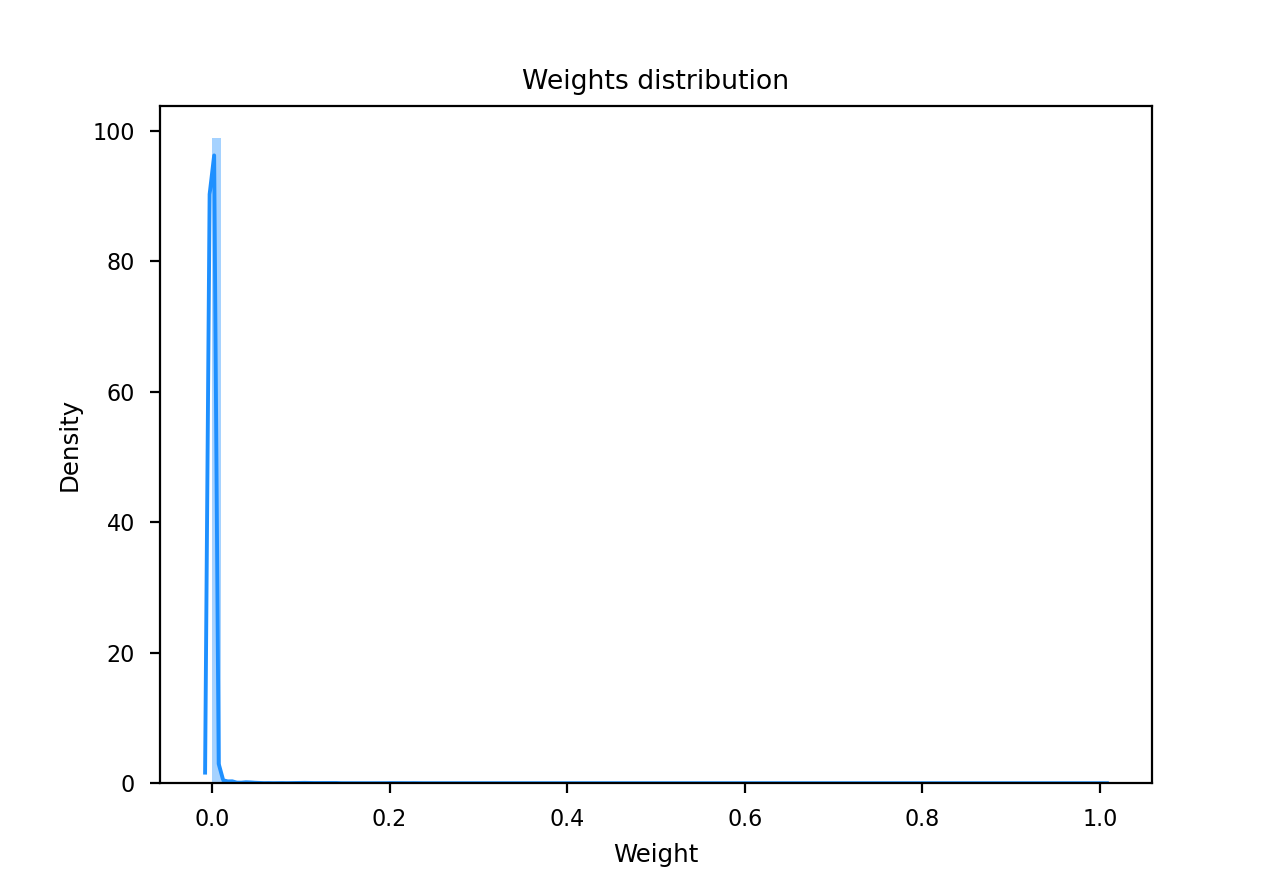

In [18]:
'''How to set the threshold? Lets take a look at the distribution of the weights'''

sns.distplot(only_weights, color="dodgerblue", label="Weights", bins=100)

plt.title('Weights distribution')
plt.xlabel('Weight')
plt.savefig('../_generated_data/Weights_distribution', dpi=1000)

plt.show()

In [20]:
print('max: ', max(only_weights)) 
print('min: ', min(only_weights))
print('median: ',statistics.median(only_weights)) 

max:  1.0
min:  4.793922427079444e-07
median:  1.396096634166118e-05


In [21]:
print('Total number of weights (links):', len(only_weights))

Total number of weights (links): 19179


In [22]:
sorted([w for w in only_weights if w > 0.5])[int(len([w for w in only_weights if w > 0.5])*80/100)]

0.8908423978217936

In [19]:
def cut_weights_threshold(final_weights, threshold):
    '''It returns the edges that holds in the network after using a given threshold'''
    final_edges = []
    for e1, e2, w in final_weights:
        if w > threshold: #weights that are above a defined threshold
            tmp = (e1, e2, w)
            final_edges.append(tmp)
    return final_edges

def network_with_threshold(g, threshold = 0, prints = True):
    '''It returns a network g using a given threshold.
    If no threshold is provided, the default value is 0. If prints
    is False, the prints will be desactivated'''
    
    G = g.copy()
    final_edges = cut_weights_threshold(final_weights, threshold)
    G = nx.empty_graph()
    G.add_weighted_edges_from(final_edges)
    #G = G.subgraph(max(nx.connected_components(G), key=len))

    if prints == True:
        print('Size: ', G.size())
        print('Number of nodes: ', G.number_of_nodes())

    return G

Size:  591
Number of nodes:  190


<IPython.core.display.Javascript object>


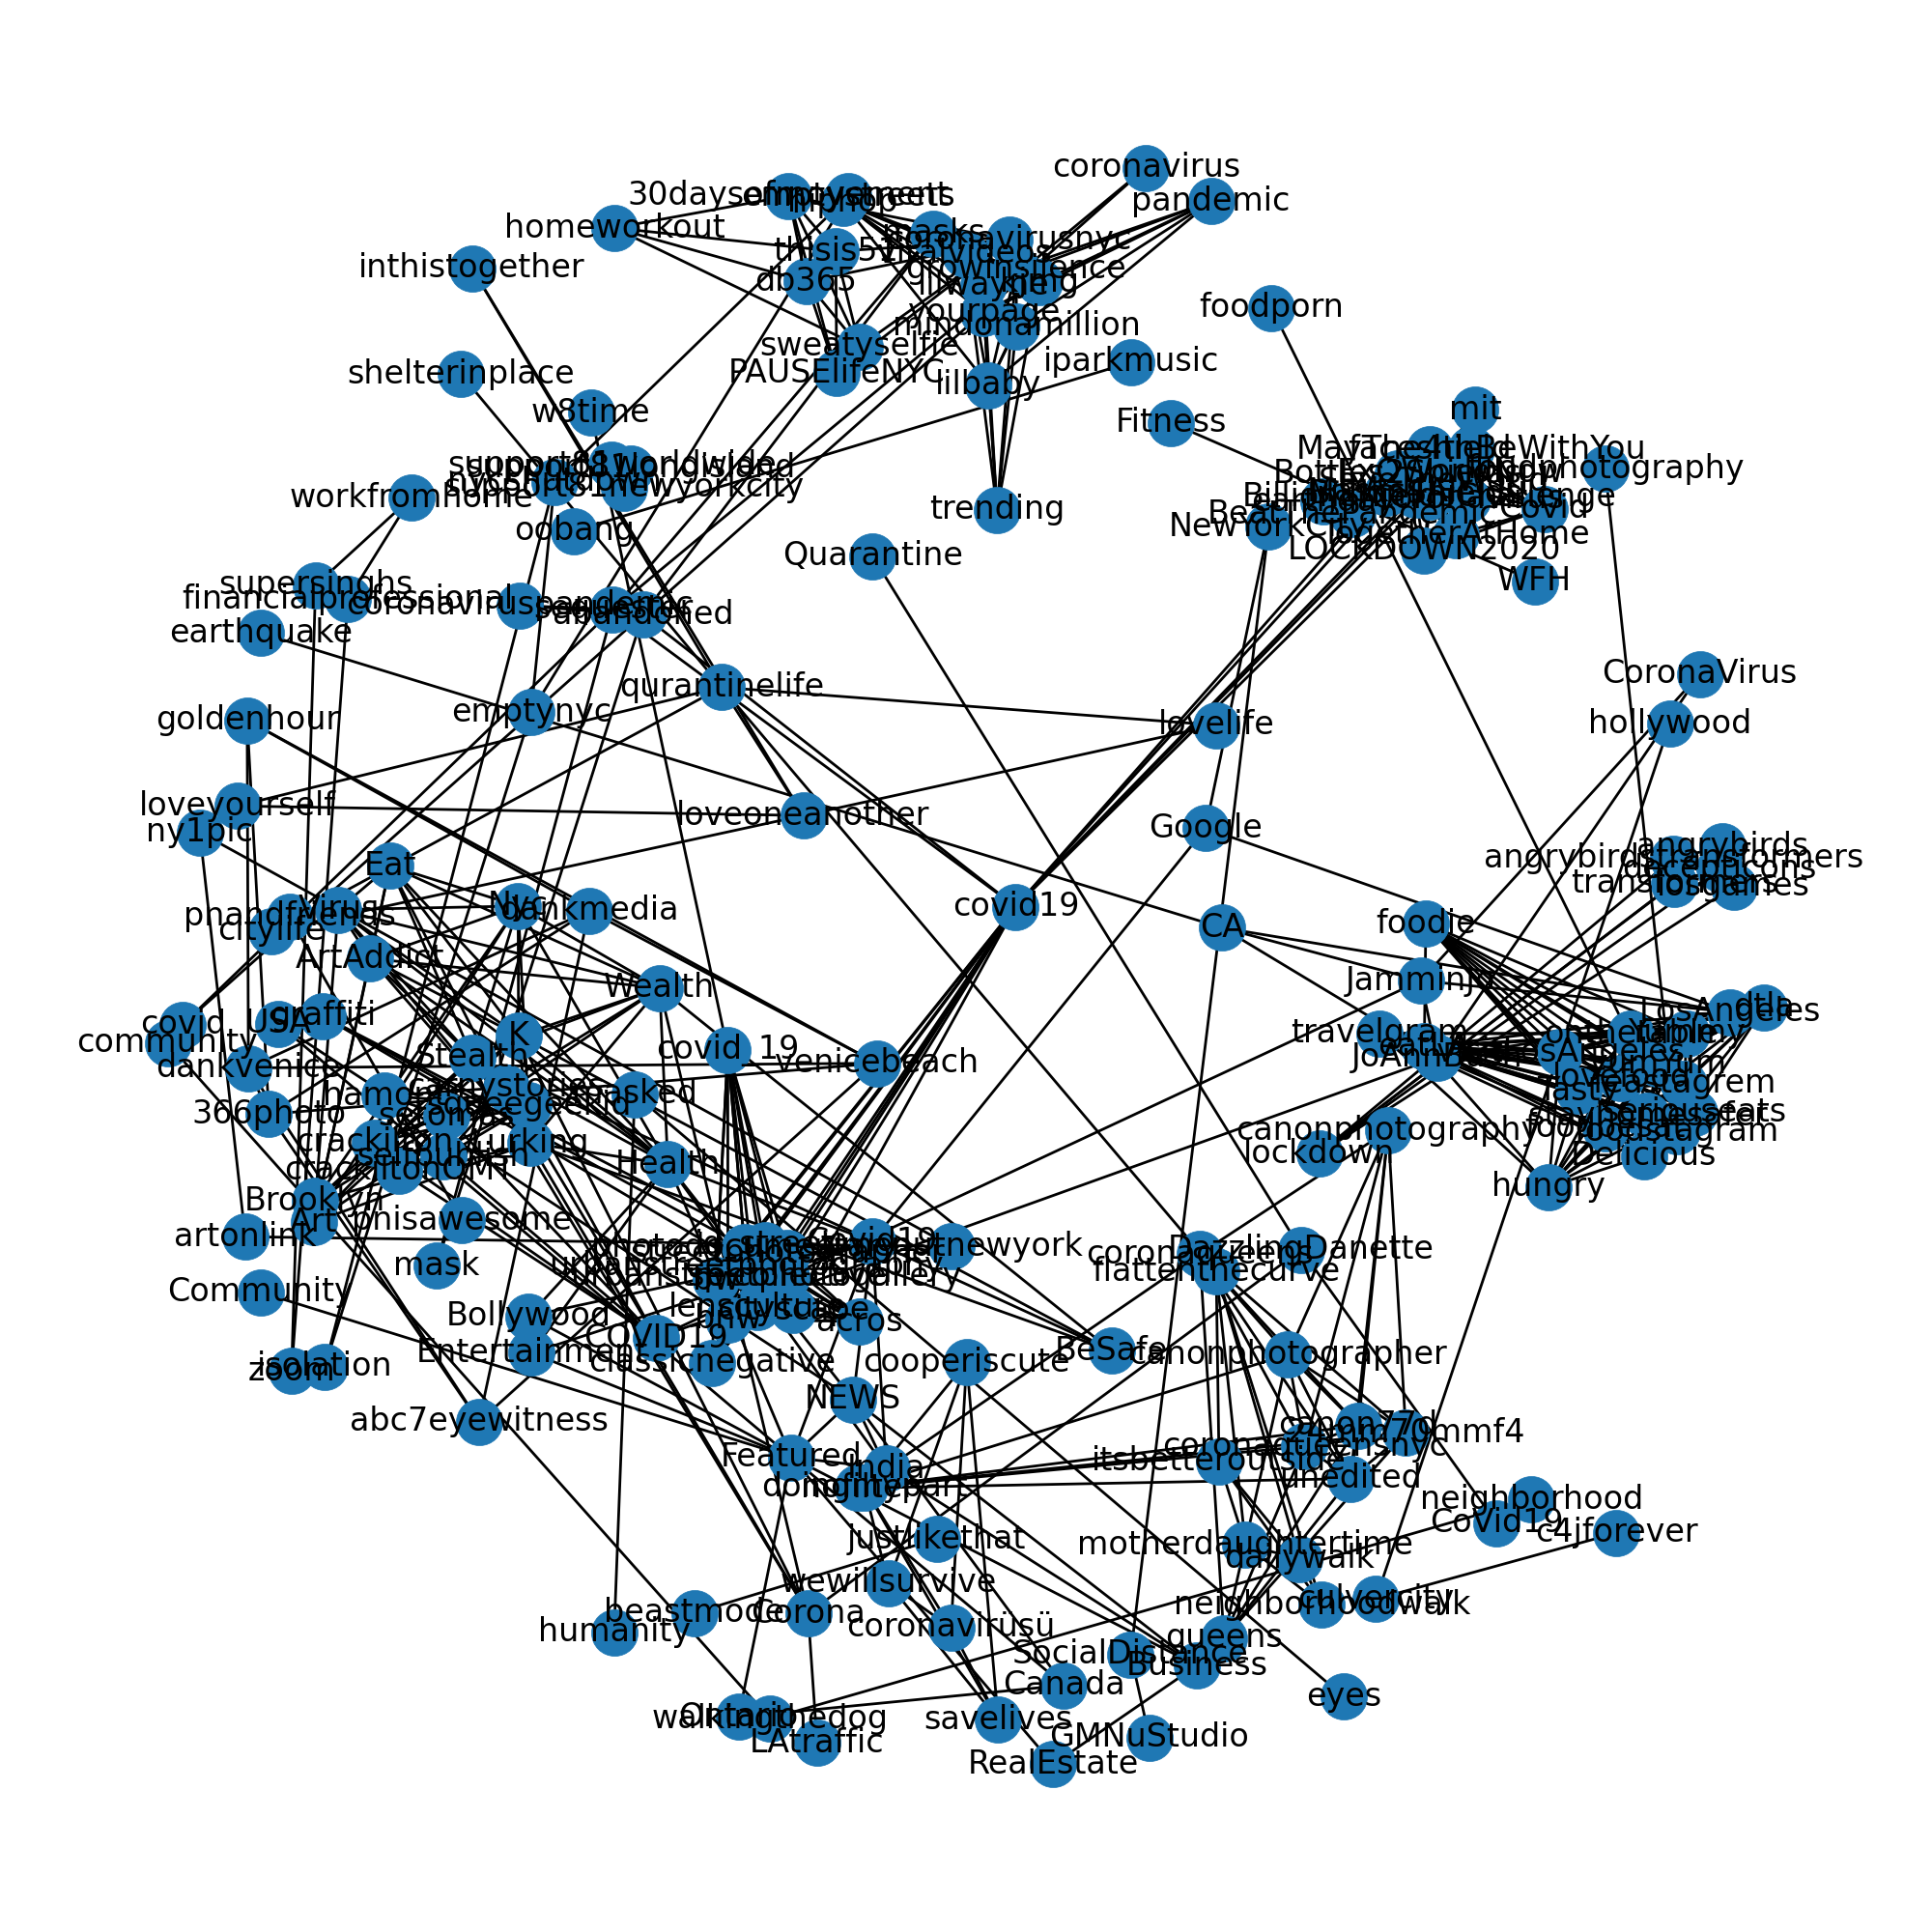

In [24]:
G_plot = network_with_threshold(G, 0.001)
plt.figure(figsize=(10,10))
nx.draw(G_plot, pos=nx.spring_layout(G_plot),with_labels = True) 

# To characterize the network
Produce some measures to characterize the network at different weight thresholds.


In [25]:
j = 0
nodes = list(G.nodes())
print(G.degree(nodes[j]))

389


In [26]:
def average_degree(G):
    avg_degree = 0
    j = 0 
    sumDeg = 0 #This is going to work if the Network has at least one node, which is the case.
    nodes = list(G.nodes())
    #G.degree(nodes[j])

    while j < G.number_of_nodes(): 
        #sumDeg = sumDeg + nx.degree(G)[j]
        sumDeg = sumDeg + G.degree(nodes[j])
        j += 1
    avg_degree = sumDeg / G.number_of_nodes()
    return avg_degree

def sigma_z(G):
    z_2 = 0
    j = 0 
    sumDeg = 0 #This is going to work if the Network has at least one node, which is the case.
    nodes = list(G.nodes())
    
    while j < G.number_of_nodes(): #becareful with the end
        sumDeg = sumDeg + G.degree(nodes[j])**2
        j += 1

    z_2 = sumDeg / G.number_of_nodes()

    z__2 = 0
    j = 0
    sumDeg = 0 #This is going to work if the Network has at least one node, which is the case.

    while j < G.number_of_nodes():
        sumDeg = sumDeg + G.degree(nodes[j])
        j += 1

    z__2 = (sumDeg / G.number_of_nodes())**2

    sigma_z = math.sqrt(z_2 - z__2)

    return(sigma_z)

def measures(G):
    N = G.number_of_nodes()

    #L = number of edges
    L = G.number_of_edges()

    #⟨z⟩ = avg_degree
    avg_degree = average_degree(G)

    #σ_z = sig_z
    sig_z = sigma_z(G)

    #Cnet
    Cnet = nx.transitivity(G)
    
    to_check_size = G.subgraph(max(nx.connected_components(G), key=len))
    N_largest_comp = nx.number_of_nodes(to_check_size)
    
    if nx.connected.is_connected(G):
        #⟨⟨d⟩⟩
        avg_avgd = nx.average_shortest_path_length(G)

        #d_diam
        d_diam = nx.diameter(G)

    else:
        G_con_subg = G.subgraph(max(nx.connected_components(G), key=len))

        #⟨⟨d⟩⟩
        avg_avgd = nx.average_shortest_path_length(G_con_subg)

        #d_diam
        d_diam = nx.diameter(G_con_subg)

    return N, L, avg_degree, sig_z, Cnet, N_largest_comp, avg_avgd, d_diam

def calculate_measures(G, list_thresholds):
    N_g = []
    L_g = []
    avg_degree_g = []
    sig_z_g = []
    Cnet_g = []
    N_largest_comp_g = []
    avg_avgd_g = []
    d_diam_g = []
    
    for t in list_thresholds:
        g_threshold = network_with_threshold(G, t, False)
        N, L, avg_degree, sig_z, Cnet, N_largest_comp, avg_avgd, d_diam = measures(g_threshold)
        N_g.append(N)
        L_g.append(L)
        avg_degree_g.append(avg_degree)
        sig_z_g.append(sig_z)
        Cnet_g.append(Cnet)
        N_largest_comp_g.append(N_largest_comp)
        avg_avgd_g.append(avg_avgd)
        d_diam_g.append(d_diam)
        
    return N_g, L_g, avg_degree_g, sig_z_g, Cnet_g, N_largest_comp_g, avg_avgd_g, d_diam_g

In [27]:
average_degree(G)

74.05019305019304

In [29]:
list_thresholds = np.linspace(0.000002, 0.9999, 1000)
measures_tup = calculate_measures(G, list_thresholds)
with open('../_generated_data/measuresv3.pickle', 'wb') as f:
    pickle.dump(measures_tup, f)

<IPython.core.display.Javascript object>


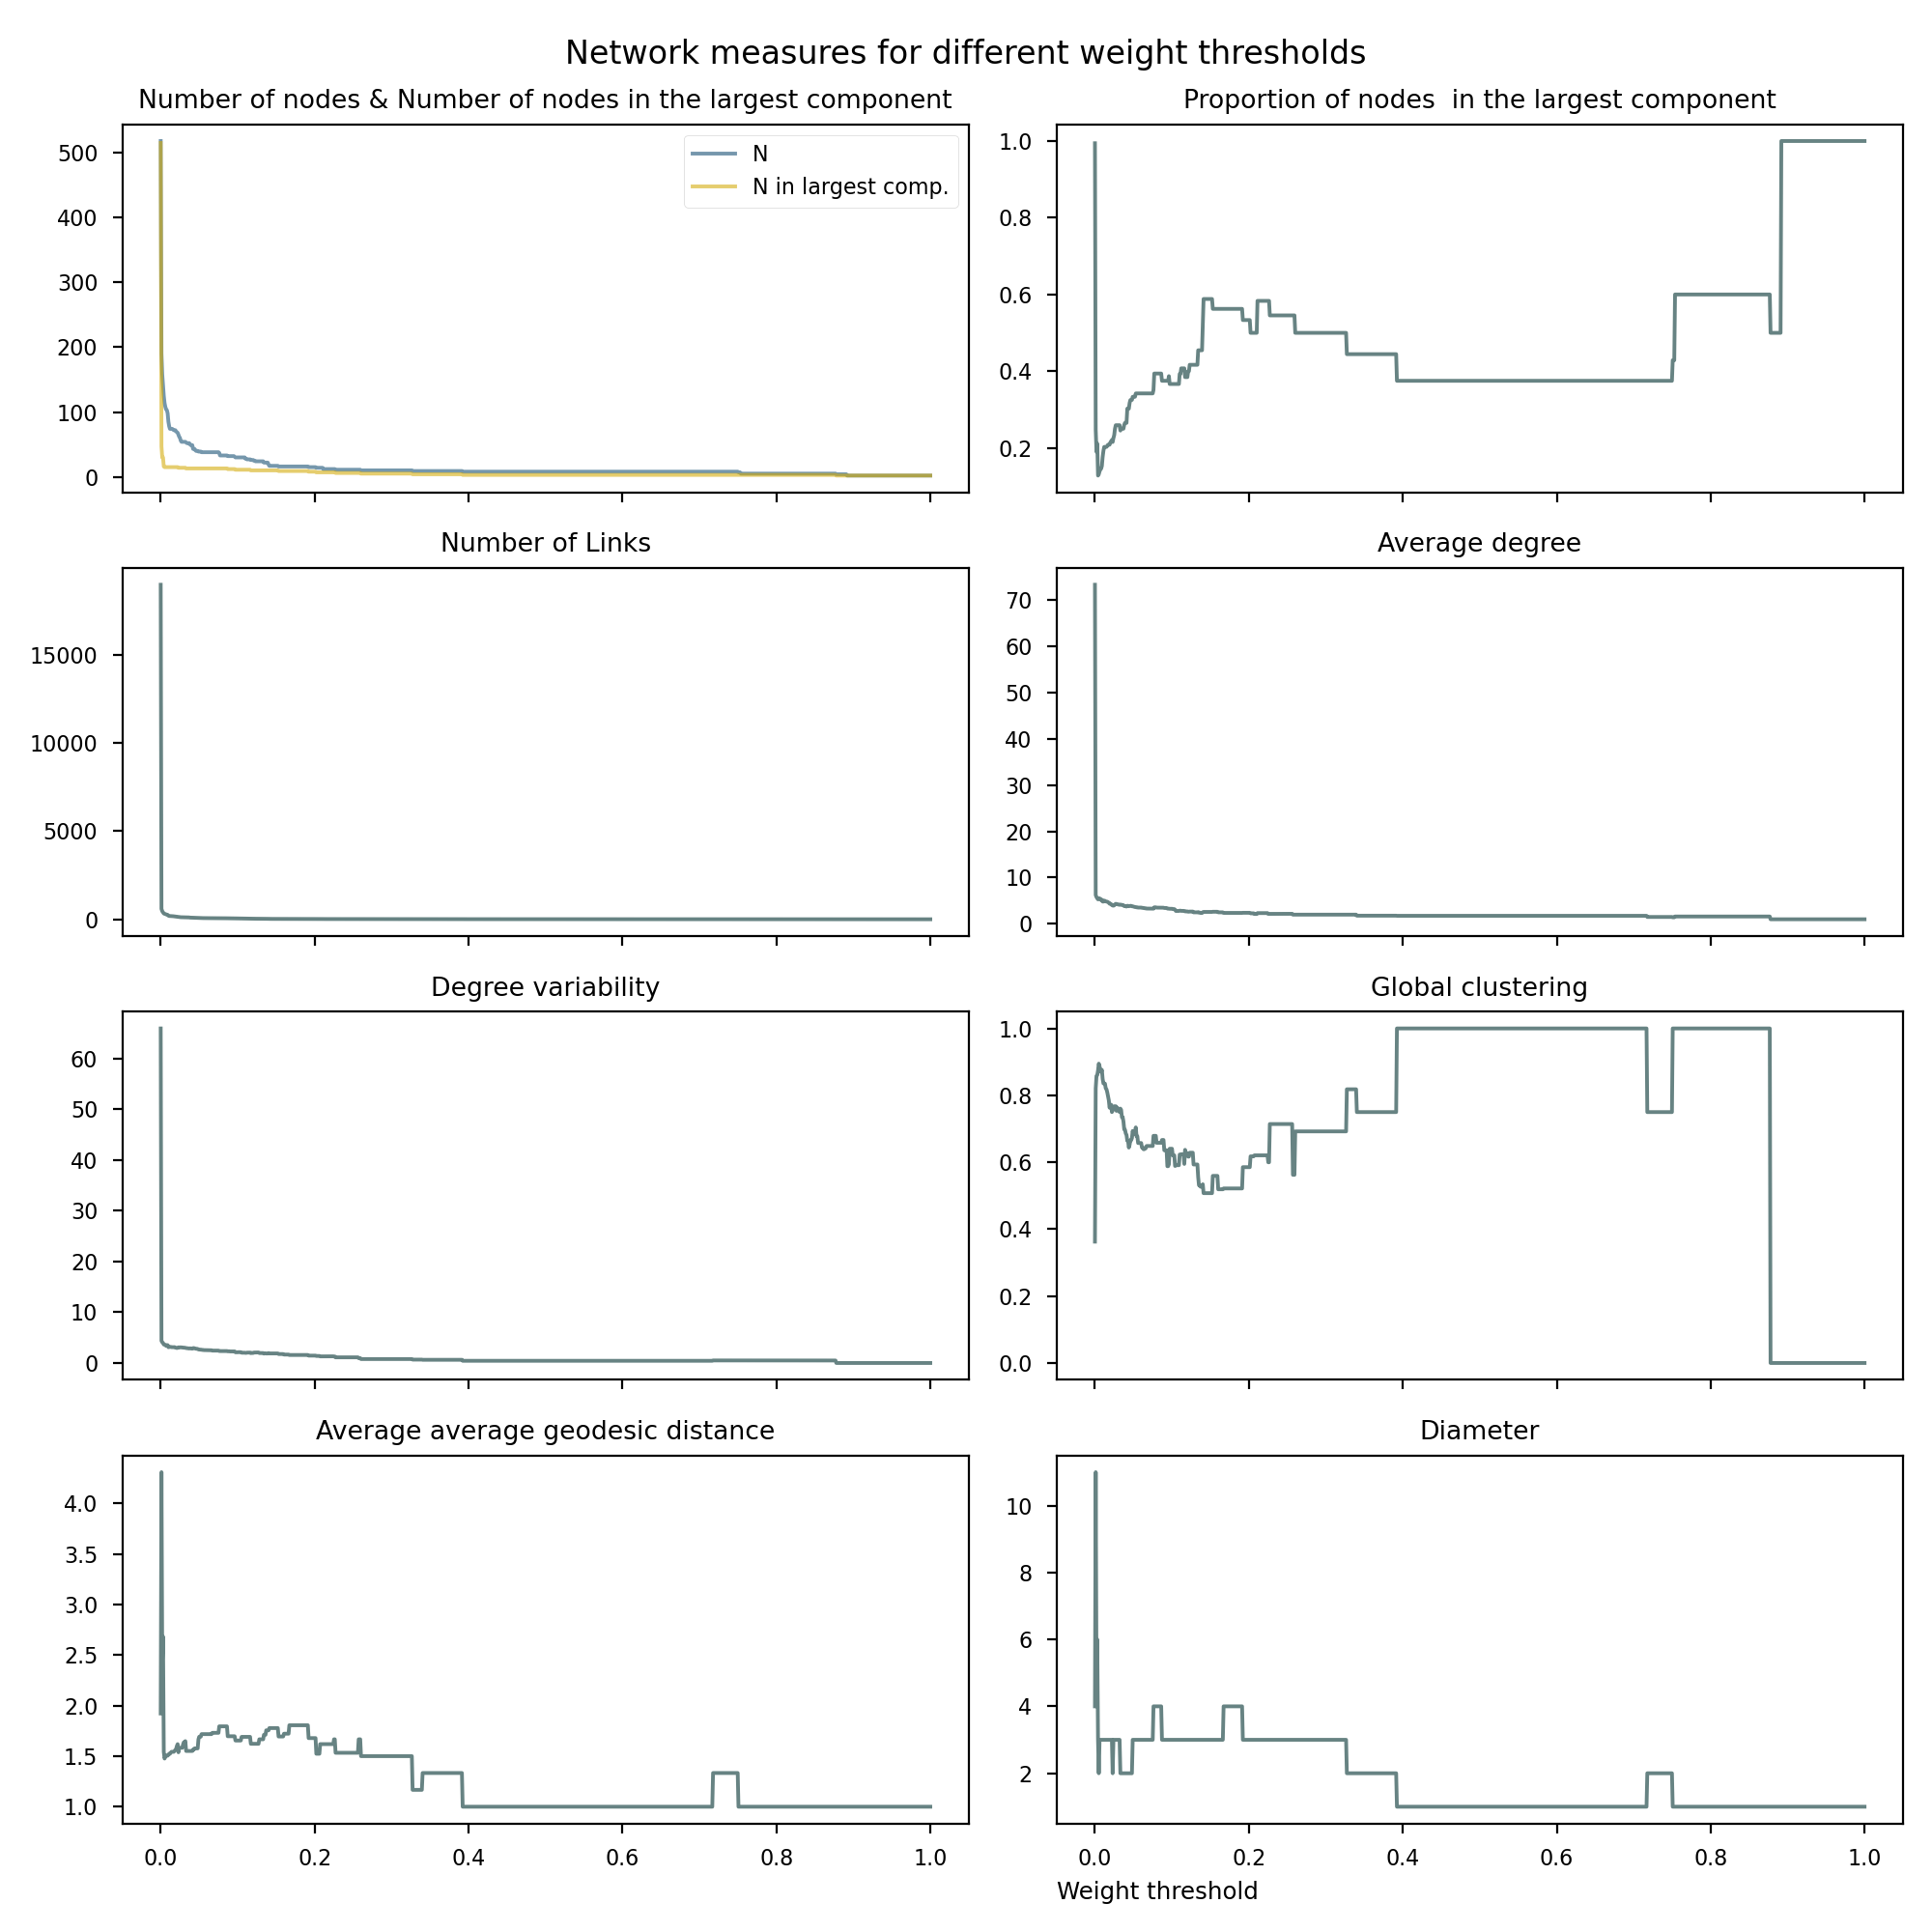

In [98]:
list_thresholds = np.linspace(0.000002, 0.9999, 1000)
with open('../_generated_data/measuresv3.pickle', 'rb') as f:
     measures_tup = pickle.load(f)
fig, ((ax1, ax6), (ax2, ax3), (ax4, ax5), (ax7, ax8)) = plt.subplots(4, 2, figsize = (10,10), 
                                                                     sharex=True)
fig.suptitle('Network measures for different weight thresholds')
ax1.set_title('Number of nodes & Number of nodes in the largest component')
ax1.plot(list_thresholds, measures_tup[0], alpha = 0.6, color = '#1A5276', 
         label='N')
ax1.plot(list_thresholds, measures_tup[5], alpha = 0.6, color = '#D4AC0D', 
         label='N in largest comp.')

ax1.legend()

ax6.set_title('Proportion of nodes  in the largest component')
prop = list(map(truediv, measures_tup[5], measures_tup[0]))
ax6.plot(list_thresholds, prop, alpha = 0.6, color = '#023130', label='N in largest comp.')


ax2.set_title('Number of Links')
ax2.plot(list_thresholds, measures_tup[1], alpha = 0.6, color = '#023130')

ax3.set_title('Average degree')
ax3.plot(list_thresholds, measures_tup[2], alpha = 0.6, color = '#023130')

ax4.set_title('Degree variability')
ax4.plot(list_thresholds, measures_tup[3], alpha = 0.6, color = '#023130')

ax5.set_title('Global clustering')
ax5.plot(list_thresholds, measures_tup[4], alpha = 0.6, color = '#023130')

ax7.set_title('Average average geodesic distance')
ax7.plot(list_thresholds, measures_tup[6], alpha = 0.6, color = '#023130')


ax8.set_title('Diameter')
ax8.plot(list_thresholds, measures_tup[7], alpha = 0.6, color = '#023130')


plt.xlabel('Weight threshold', loc='left')
plt.tight_layout()
plt.savefig('../_generated_data/Measures0.png', dpi=1000)
plt.show()
#for ax in fig.get_axes():
 #   ax.label_outer()

In [31]:
list_thresholds = np.linspace(0.00002, 0.1, 1000)
measures_tup = calculate_measures(G, list_thresholds)
with open('../_generated_data/measures_2v4.pickle', 'wb') as f:
    pickle.dump(measures_tup, f)

<IPython.core.display.Javascript object>


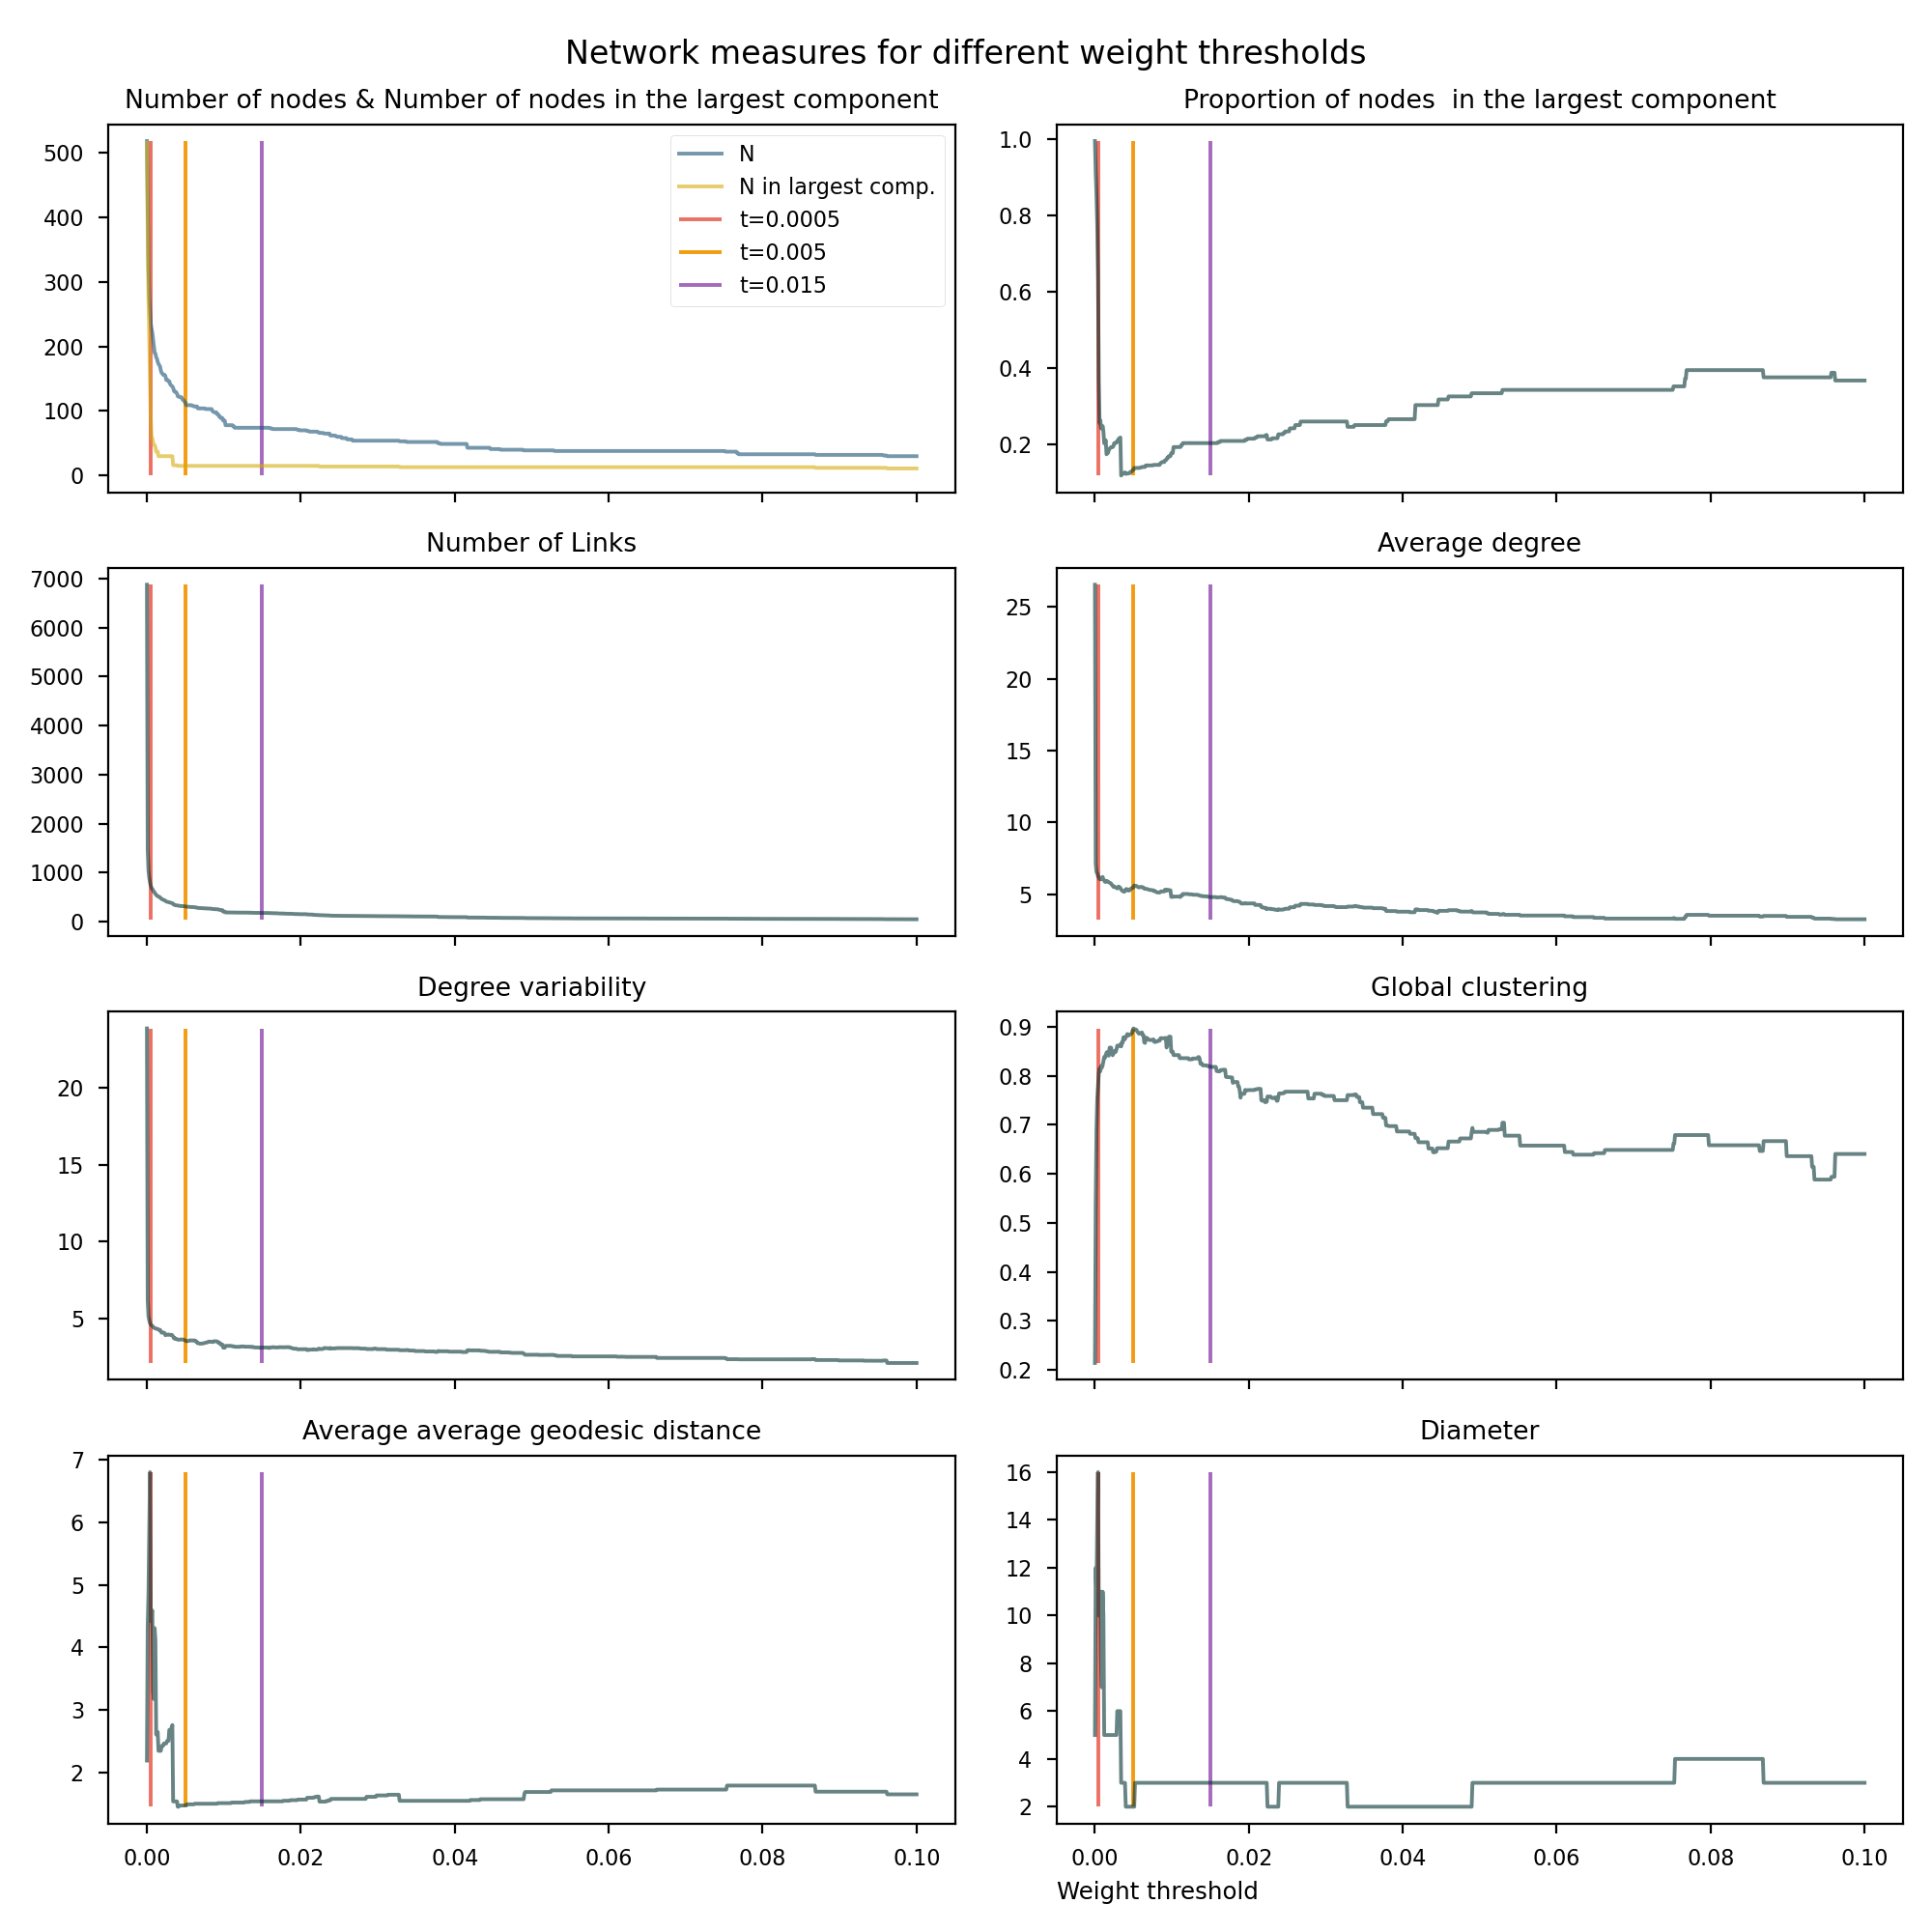

In [97]:
with open('../_generated_data/measures_2v4.pickle', 'rb') as f:
    measures_tup = pickle.load(f)
list_thresholds = np.linspace(0.00002, 0.1, 1000)

t1 = 0.0005
t2 = 0.005
t3 = 0.015

fig, ((ax1, ax6), (ax2, ax3), (ax4, ax5), (ax7, ax8)) = plt.subplots(4, 2, figsize = (10,10), 
                                                                     sharex=True)
fig.suptitle('Network measures for different weight thresholds')
ax1.set_title('Number of nodes & Number of nodes in the largest component')
ax1.plot(list_thresholds, measures_tup[0], alpha = 0.6, color = '#1A5276', 
         label='N')
ax1.plot(list_thresholds, measures_tup[5], alpha = 0.6, color = '#D4AC0D', 
         label='N in largest comp.')
ax1.vlines(t1, 0, max(measures_tup[0]), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax1.vlines(t2, 0, max(measures_tup[0]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax1.vlines(t3, 0, max(measures_tup[0]), colors='#A569BD', 
           label = 't={}'.format(t3), linestyles='solid')
ax1.legend()

ax6.set_title('Proportion of nodes  in the largest component')
prop = list(map(truediv, measures_tup[5], measures_tup[0]))
ax6.plot(list_thresholds, prop, alpha = 0.6, color = '#023130', label='N in largest comp.')
ax6.vlines(t1, min(prop), max(prop), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax6.vlines(t2, min(prop), max(prop), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax6.vlines(t3, min(prop), max(prop),colors='#A569BD', 
           label = 't={}'.format(t3),linestyles='solid')


ax2.set_title('Number of Links')
ax2.plot(list_thresholds, measures_tup[1], alpha = 0.6, color = '#023130')
ax2.vlines(t1, min(measures_tup[1]), max(measures_tup[1]), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax2.vlines(t2, min(measures_tup[1]), max(measures_tup[1]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax2.vlines(t3, min(measures_tup[1]), max(measures_tup[1]), colors='#A569BD', 
           label = 't={}'.format(t3),linestyles='solid')
ax3.set_title('Average degree')
ax3.plot(list_thresholds, measures_tup[2], alpha = 0.6, color = '#023130')
ax3.vlines(t1, min(measures_tup[2]), max(measures_tup[2]), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax3.vlines(t2, min(measures_tup[2]), max(measures_tup[2]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax3.vlines(t3, min(measures_tup[2]), max(measures_tup[2]), colors='#A569BD', 
           label = 't={}'.format(t3), linestyles='solid')
ax4.set_title('Degree variability')
ax4.plot(list_thresholds, measures_tup[3], alpha = 0.6, color = '#023130')
ax4.vlines(t1, min(measures_tup[3]), max(measures_tup[3]), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax4.vlines(t2, min(measures_tup[3]), max(measures_tup[3]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax4.vlines(t3, min(measures_tup[3]), max(measures_tup[3]), colors='#A569BD', 
           label = 't={}'.format(t3),
           linestyles='solid')
ax5.set_title('Global clustering')
ax5.plot(list_thresholds, measures_tup[4], alpha = 0.6, color = '#023130')
ax5.vlines(t1, min(measures_tup[4]), max(measures_tup[4]), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax5.vlines(t2, min(measures_tup[4]), max(measures_tup[4]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax5.vlines(t3, min(measures_tup[4]), max(measures_tup[4]), colors='#A569BD', 
           label = 't={}'.format(t1),linestyles='solid')

ax7.set_title('Average average geodesic distance')
ax7.plot(list_thresholds, measures_tup[6], alpha = 0.6, color = '#023130')
ax7.vlines(t1, min(measures_tup[6]), max(measures_tup[6]), colors='#EC7063', 
           label = 't={}'.format(t2), linestyles='solid')
ax7.vlines(t2, min(measures_tup[6]), max(measures_tup[6]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax7.vlines(t3, min(measures_tup[6]), max(measures_tup[6]), colors='#A569BD', 
           label = 't={}'.format(t3),linestyles='solid')
ax8.set_title('Diameter')
ax8.plot(list_thresholds, measures_tup[7], alpha = 0.6, color = '#023130')
ax8.vlines(t1, min(measures_tup[7]), max(measures_tup[7]), colors='#EC7063', 
           label = 't={}'.format(t1), linestyles='solid')
ax8.vlines(t2, min(measures_tup[7]), max(measures_tup[7]), colors='#F39C12', 
           label = 't={}'.format(t2),linestyles='solid')
ax8.vlines(t3, min(measures_tup[7]), max(measures_tup[7]), colors='#A569BD', 
           label = 't={}'.format(t1), linestyles='solid')

plt.xlabel('Weight threshold', loc='left')
plt.tight_layout()
plt.savefig('../_generated_data/Measures.png', dpi=1000)
plt.show()
#for ax in fig.get_axes():
 #   ax.label_outer()

In [68]:
t = 0.0005
g_threshold = network_with_threshold(G, t, False)
N, L, avg_degree, sig_z, Cnet, N_largest_comp, avg_avgd, d_diam = measures(g_threshold)
print('With threshold = {}:'.format(t))
print('The number of nodes N is {}' .format(N))
print('The number of edges is {}' .format(L))
print('The average degree ⟨z⟩ is {:.4f}' .format(avg_degree))
print('The degree variability σz is {:.4f}' .format(sig_z))
print('The global clustering Cnet is {:.4f}' .format(Cnet))
print('The average average geodesic distance ⟨⟨d⟩⟩ is {:.4f}' .format(avg_avgd))
print('The diameter d_diam is {} ' .format(d_diam))
print('Note that the number of nodes of the largest component is {}, and the proportion with respect the total nodes is {:.1f}' .format(N_largest_comp, (N_largest_comp/N)))

With threshold = 0.0005:
The number of nodes N is 242
The number of edges is 741
The average degree ⟨z⟩ is 6.1240
The degree variability σz is 4.6177
The global clustering Cnet is 0.8012
The average average geodesic distance ⟨⟨d⟩⟩ is 4.3726
The diameter d_diam is 10 
Note that the number of nodes of the largest component is 86, and the proportion with respect the total nodes is 0.4


In [69]:
t = 0.005
g_threshold = network_with_threshold(G, t, False)
N, L, avg_degree, sig_z, Cnet, N_largest_comp, avg_avgd, d_diam = measures(g_threshold)
print('With threshold = {}:'.format(t))
print('The number of nodes N is {}' .format(N))
print('The number of edges is {}' .format(L))
print('The average degree ⟨z⟩ is {:.4f}' .format(avg_degree))
print('The degree variability σz is {:.4f}' .format(sig_z))
print('The global clustering Cnet is {:.4f}' .format(Cnet))
print('The average average geodesic distance ⟨⟨d⟩⟩ is {:.4f}' .format(avg_avgd))
print('The diameter d_diam is {} ' .format(d_diam))
print('Note that the number of nodes of the largest component is {}, and the proportion with respect the total nodes is {:.1f}' .format(N_largest_comp, (N_largest_comp/N)))

With threshold = 0.005:
The number of nodes N is 114
The number of edges is 311
The average degree ⟨z⟩ is 5.4561
The degree variability σz is 3.6108
The global clustering Cnet is 0.8948
The average average geodesic distance ⟨⟨d⟩⟩ is 1.4762
The diameter d_diam is 2 
Note that the number of nodes of the largest component is 15, and the proportion with respect the total nodes is 0.1


In [70]:
t = 0.015
g_threshold = network_with_threshold(G, t, False)
N, L, avg_degree, sig_z, Cnet, N_largest_comp, avg_avgd, d_diam = measures(g_threshold)
print('With threshold = {}:'.format(t))
print('The number of nodes N is {}' .format(N))
print('The number of edges is {}' .format(L))
print('The average degree ⟨z⟩ is {:.4f}' .format(avg_degree))
print('The degree variability σz is {:.4f}' .format(sig_z))
print('The global clustering Cnet is {:.4f}' .format(Cnet))
print('The average average geodesic distance ⟨⟨d⟩⟩ is {:.4f}' .format(avg_avgd))
print('The diameter d_diam is {} ' .format(d_diam))
print('Note that the number of nodes of the largest component is {}, and the proportion with respect the total nodes is {:.1f}' .format(N_largest_comp, (N_largest_comp/N)))

With threshold = 0.015:
The number of nodes N is 74
The number of edges is 178
The average degree ⟨z⟩ is 4.8108
The degree variability σz is 3.1178
The global clustering Cnet is 0.8179
The average average geodesic distance ⟨⟨d⟩⟩ is 1.5429
The diameter d_diam is 3 
Note that the number of nodes of the largest component is 15, and the proportion with respect the total nodes is 0.2


<IPython.core.display.Javascript object>


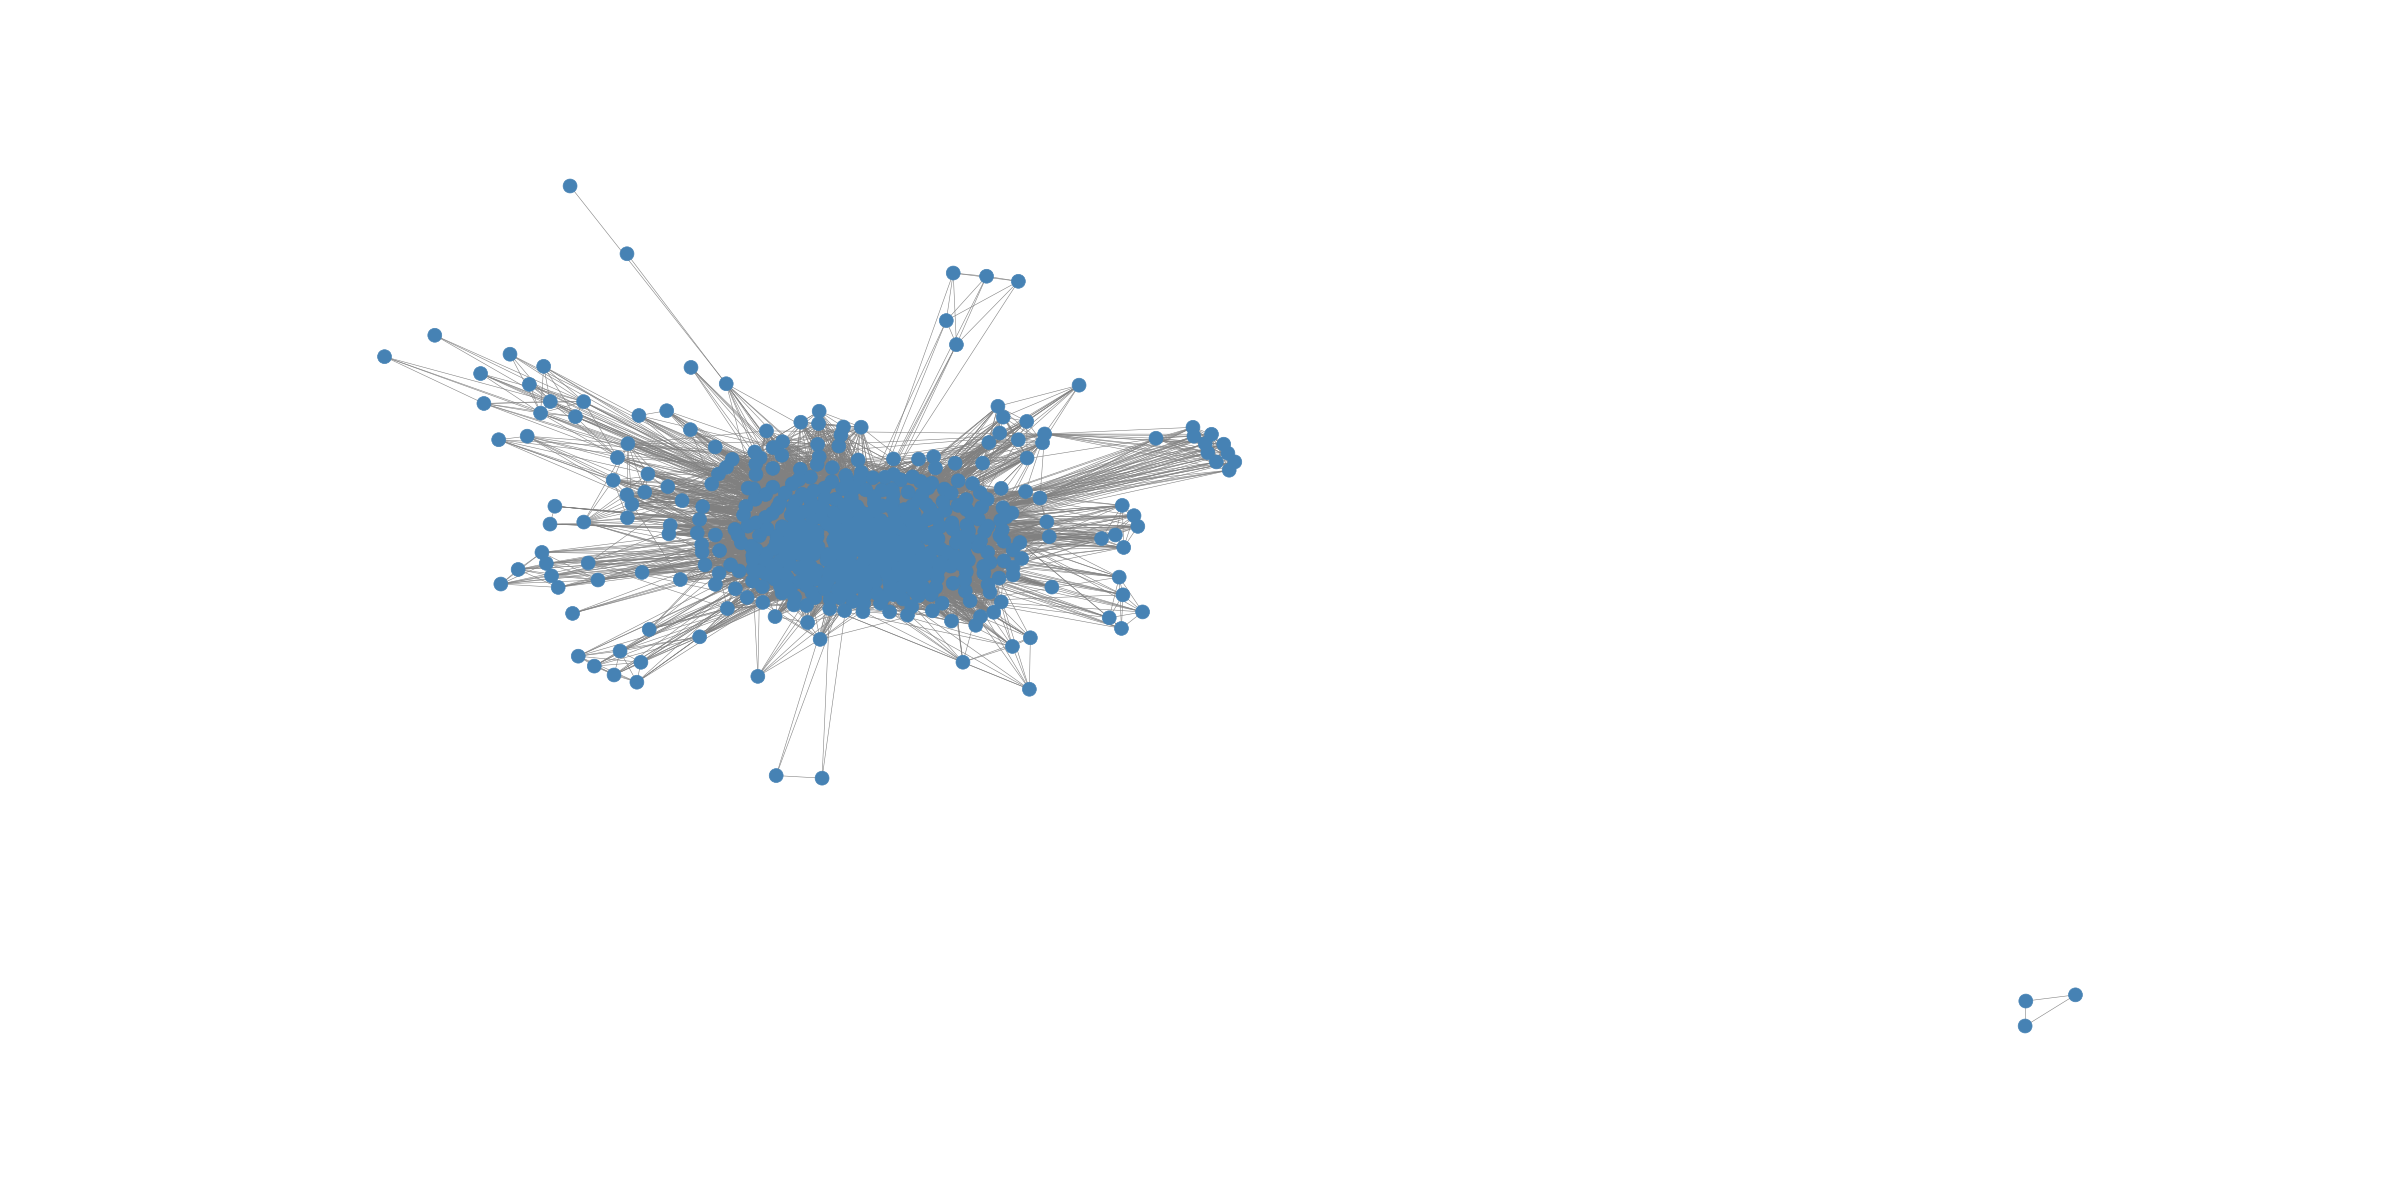

In [41]:
''' To convert to igraph'''
h = ig.Graph.from_networkx(G)
h.es[0].attributes()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
layout = h.layout_kamada_kawai()
#ig.plot(h, layout='auto', target='test.pdf') to print to a file
ig.plot(h, layout='auto', 
        edge_width=.2,
        edge_color='grey',
        #vertex_size=h.degree(),
        target=ax,
       label = h.vs['_nx_name'])
plt.axis("off")
plt.show()

In [37]:
sorted_clustering = dict(nx.clustering(G))
sorted_clustering = dict(sorted(sorted_clustering.items(), key=lambda item: item[1], reverse = True))
first_30_sorted_clustering = list(sorted_clustering)[:30]
for node in first_30_sorted_clustering:
    print(node, ': ', sorted_clustering[node])

visitLosAngeles :  1.0
foodbesat :  1.0
eatLA :  1.0
feastagrem :  1.0
lovefood :  1.0
onthetable :  1.0
seriouseats :  1.0
stayhomesafer :  1.0
yumYum :  1.0
Tasty :  1.0
kjmg :  1.0
growinsilence :  1.0
mindonamillion :  1.0
yourpage :  1.0
sequester :  1.0
abandoned :  1.0
w8time :  1.0
selfpublish :  1.0
angrybirdstransformers :  1.0
angrybirds :  1.0
decepticons :  1.0
mit :  1.0
financialprofessional :  1.0
supersinghs :  1.0
BeatThePandemic :  1.0
support81worldwide :  1.0
support81longisland :  1.0
support81newyorkcity :  1.0
classicnegative :  0.9848484848484849
qurantinelife :  0.978021978021978


In [29]:
def create_palette(partition):
    '''To create an appropiate palette containing the number of colors needed'''
    n = max(partition.values()) + 1
    palette = sns.color_palette("husl", n)
    palette.as_hex()
    i = 0
    color_palette = {}
    for n in set(partition.values()):
        color_palette[n] = palette[i]
        i += 1
    return color_palette
    
def find_best_girvan_newman(G):
    '''To find the best partition using Girvan and Newman algorith.
    It will cut the following level using betweeness. If the modularity is not
    higher, it will retrieve the best result so far (the previous one)'''
    i = 0
    m = 0
    communities_generator = community.girvan_newman(G)
    next_level_communities = next(communities_generator)
    while True:
        m_tmp = community.quality.modularity(G, next_level_communities)
        if (m_tmp < m) | (abs(m_tmp - m) < 0.0001) :
            return next_level_communities
        else:
            m = m_tmp
        #print(i, ': ',m)
        next_level_communities = next(communities_generator)
        i+= 1
        
def partition_dictionary(communities):
    '''Given a list of nodes forming communities, it will retrieve a dictionary
    mentioning every node and its respective number of community'''
    partition = {}
    i = 0
    for group in list(communities):
        for node in group:
            partition[node] = i
        i += 1
    return partition

def dic_to_partition(dic):
    '''Transform a dictionary containing nodes as keys and groups or communities as values
    into a partition'''
    partition = []
    groups= set(dic.values())
    for group in groups:
        set_tmp = set([node for node, g in dic.items() if g == group])
        partition.append(set_tmp)
    return partition

def best_partition(G, algorithm, k=3, prints = True):
    ''' Compute the best partition using algorithms available:
    algorithm = ['louvain','fluid','label','girvan_newman']
    Note that 'fluid' need to set a number of groups k.'''
    
    G_c = G.copy()
    if algorithm == 'louvain':
        partition = community_louvain.best_partition(G_c, weight = 'weight', random_state = 13)
        ######
    elif algorithm == 'fluid':
        #Needs connected graph
        fluid = community.asyn_fluidc(G_c, k, max_iter=100, seed=13)
        partition = partition_dictionary(fluid)
    
    elif algorithm == 'label':
        label = list(community.label_propagation.label_propagation_communities(G_c))
        partition = partition_dictionary(label)
    
    elif algorithm == 'girvan_newman':
        girvan_newman = list(find_best_girvan_newman(G_c))
        partition = partition_dictionary(girvan_newman)
        
    number_groups = len(set(partition.values()))
    color_palette = create_palette(partition)
    groups = {}
    colors = {}
    
    for n in range(number_groups):
        l = [name for name, group in partition.items() if group == n]
        for name in l:
            groups[name] = n
            colors[name] = color_palette[n]
    
    '''Set appropiate atributes for group and associated color '''
    nx.set_node_attributes(G_c, groups, 'group')
    nx.set_node_attributes(G_c, colors, 'color')
    
    if prints == True:
        pos = nx.spring_layout(G_c)
        nx.draw_networkx_nodes(G_c, pos, partition.keys(), node_size=40,
                               node_color = list(nx.get_node_attributes(G_c,'color').values()),
                               label=list(G_c.nodes()))
        nx.draw_networkx_edges(G_c, pos, alpha=0.5)
        plt.suptitle(algorithm.capitalize() +' Community detection')
        plt.title('Number of groups:' + str(number_groups))
        plt.savefig(algorithm.capitalize() +' Community detection', dpi=300)
    
    return G_c, partition

In [39]:
nets = {}
partitions = {}
algorithm = 'label'

''' It uses an iterative method (again just like k-means): the target label will be assigned 
with the most “vote” of the lables from its neighbors; until the current label is the most 
frequent label.'''

G_label, label_partition = best_partition(G, algorithm)
nets[algorithm] = G_label
partitions[algorithm] = label_partition
plt.show()

algorithm = 'girvan_newman'
G_gn, gn_partition = best_partition(G, algorithm)
nets[algorithm] = G_gn
partitions[algorithm] = gn_partition
plt.show()

algorithm = 'louvain'
G_louvain, louvain_partition = best_partition(G, algorithm)
nets[algorithm] = G_louvain
partitions[algorithm] = louvain_partition
plt.show()

In [42]:
'''To store the partitions'''
with open('../_generated_data/Partitionsv3.pickle', 'wb') as handle:
    pickle.dump(partitions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
len(partitions)

3

In [44]:
def create_df_partitions(partitions):
    algorithm = list(partitions.keys())
    for a in algorithm:
        if a == algorithm[0]:
            df = pd.DataFrame(set(partitions[a].items()), columns=['Hashtag', a])
        else:
            df_tmp = pd.DataFrame(set(partitions[a].items()), columns=['Hashtag', a])
            df = df.merge(df_tmp, how='inner', on='Hashtag', copy=False).reset_index(drop=True)
    return df

def group(df, algorithm, hashtag):
    group = df.loc[df['Hashtag'] == hashtag][algorithm].to_numpy()[0]
    return group

def edge_coincidences_community(G, df, algorithm):
    '''Given a network G, a dataframe df containing communities with different algorithms,
    and an algorithm, it will return a list n. The list will contain a 1 per edges that 
    are in the same community, and a 0 if they are at different communities '''
    edges = list(G.edges())

    n = []
    for u, v in edges:

        group_u = group(df, algorithm, u)
        group_v = group(df, algorithm, v)

        if group_u == group_v:
            n.append(1)
        else:
            n.append(0)
    return n

def generate_edge_coincidences_community(G, df, partitions):
    algorithm = list(partitions.keys())
    edge_coincidences = {}
    for a in tqdm(algorithm):
        n = edge_coincidences_community(G, df, a)
        edge_coincidences[a] = n
    return edge_coincidences

def generate_df_nmi_ars_partitions(G, partitions, measure= 'MI_score'):
    
    '''measure = ['MI_score', 'Adj_rand_score']'''
    df = create_df_partitions(partitions)
    edge_coincidences = generate_edge_coincidences_community(G, df, partitions)
    algorithm = list(partitions.keys())
    data = []
    i = 0
    j = 0

    while i < len(algorithm):
        nmi_tmp = []
        ars_tmp = []
        while j < len(algorithm):

            a1 = algorithm[i]
            a2 = algorithm[j]

            nmi_tmp = normalized_mutual_info_score(edge_coincidences[a1], 
                                                   edge_coincidences[a2])
            ars_tmp = adjusted_rand_score(edge_coincidences[a1], edge_coincidences[a2])

            data.append([algorithm[i], algorithm[j], nmi_tmp, ars_tmp])
            j += 1
        j = 0
        i += 1
        
    df_a = pd.DataFrame(data, columns = ['Algorithm1', 'Algorithm2', 'MI_score', 'Adj_rand_score'])
    
    df_a = df_a.pivot('Algorithm1', 'Algorithm2', measure)
    
    return df_a

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


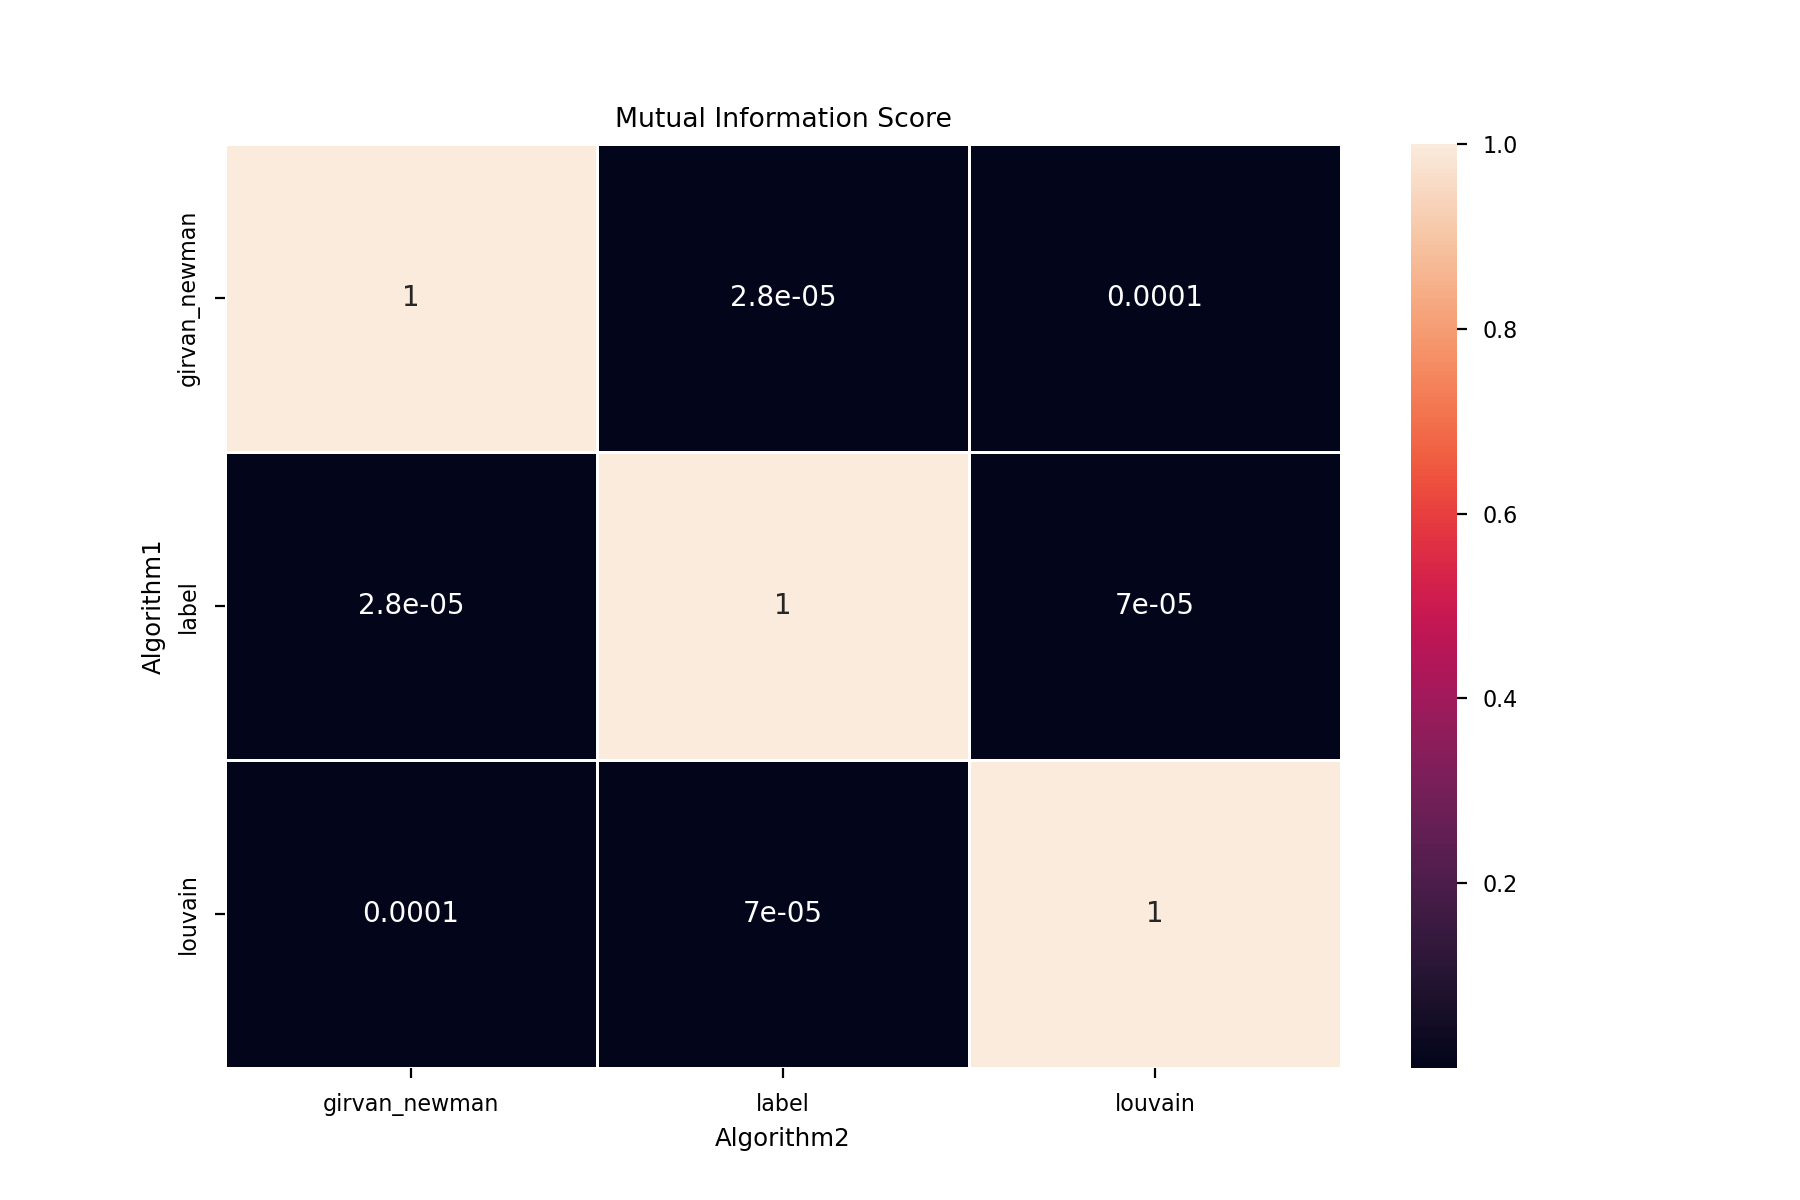

In [45]:
df_a = generate_df_nmi_ars_partitions(G, partitions)
df_a.head()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_a, annot=True, linewidths=.5, ax=ax)
plt.title('Mutual Information Score')
plt.show()

# Quality of the partitions

In [47]:
modularity = {}
coverage = {}
performance = {}
n_communities = {}
#The performance of a partition is the number of intra-community edges plus inter-community 
#non-edges divided by the total number of potential edges.
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.performance.html#networkx.algorithms.community.quality.performance
for algorithm, partition in partitions.items():
    p = dic_to_partition(partition)
    coverage[algorithm] = community.quality.coverage(G, p)
    performance[algorithm] = community.quality.partition_quality(G, p)[1]
    modularity[algorithm] = community.quality.modularity(G, p)
    n_communities[algorithm] = len(set(partitions[algorithm].values()))

<IPython.core.display.Javascript object>


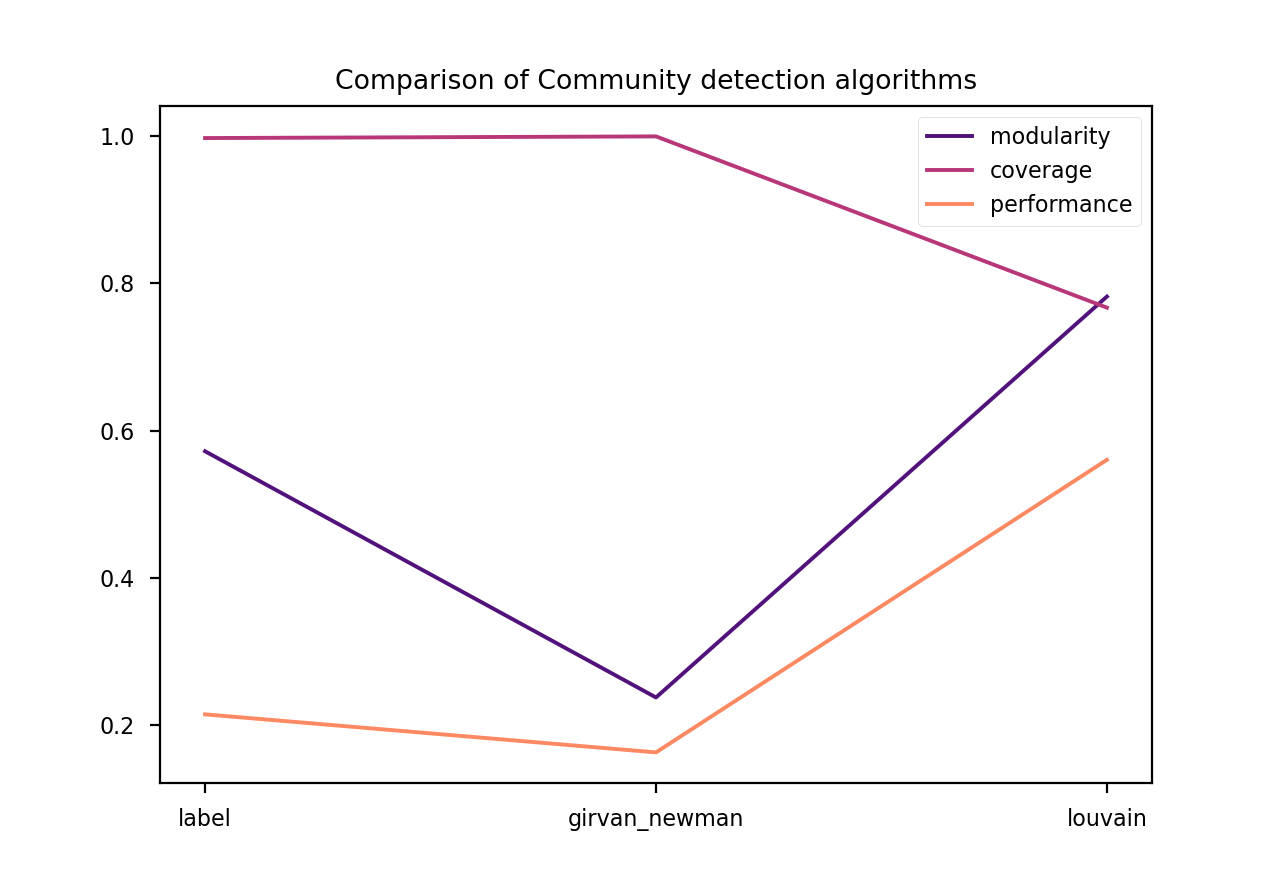

In [48]:
plt.figure()

colors = sns.color_palette("magma", 3)
plt.plot(modularity.keys(), modularity.values(), label = 'modularity', color = colors[0])
x = 0
y = 0

plt.plot(coverage.keys(), coverage.values(), label = 'coverage', color = colors[1])
plt.plot(performance.keys(), performance.values(), label = 'performance', color = colors[2])
plt.plot()
plt.legend()
i = 0
l = []
for v in n_communities.values():
    plt.annotate('N:'+ str(v), (list(modularity.keys())[i], 0.0))
    l.append('N:'+ str(v))
    i += 1
plt.title('Comparison of Community detection algorithms')
plt.show()

# Different thresholds

In [33]:
thresholds = np.linspace(0.00002, 0.9, 100)

nets_t = {}
partitions_t = {}
algorithm = 'label'
for t in thresholds:
    g_tmp = nx.empty_graph()
    g_tmp = network_with_threshold(G, t, False)
    G_label, label_partition = best_partition(g_tmp, algorithm, False)
    nets_t[algorithm+str(t)] = G_label
    partitions_t[algorithm+str(t)] = label_partition

In [34]:
modularity = {}
coverage = {}
performance = {}
n_communities = {}
for algorithm, partition in partitions_t.items():
    p = dic_to_partition(partition)
    coverage[algorithm] = community.quality.coverage(nets_t[algorithm], p)
    performance[algorithm] = community.quality.partition_quality(nets_t[algorithm], p)[1]
    modularity[algorithm] = community.quality.modularity(nets_t[algorithm], p)
    n_communities[algorithm] = len(set(partitions_t[algorithm].values()))

<IPython.core.display.Javascript object>


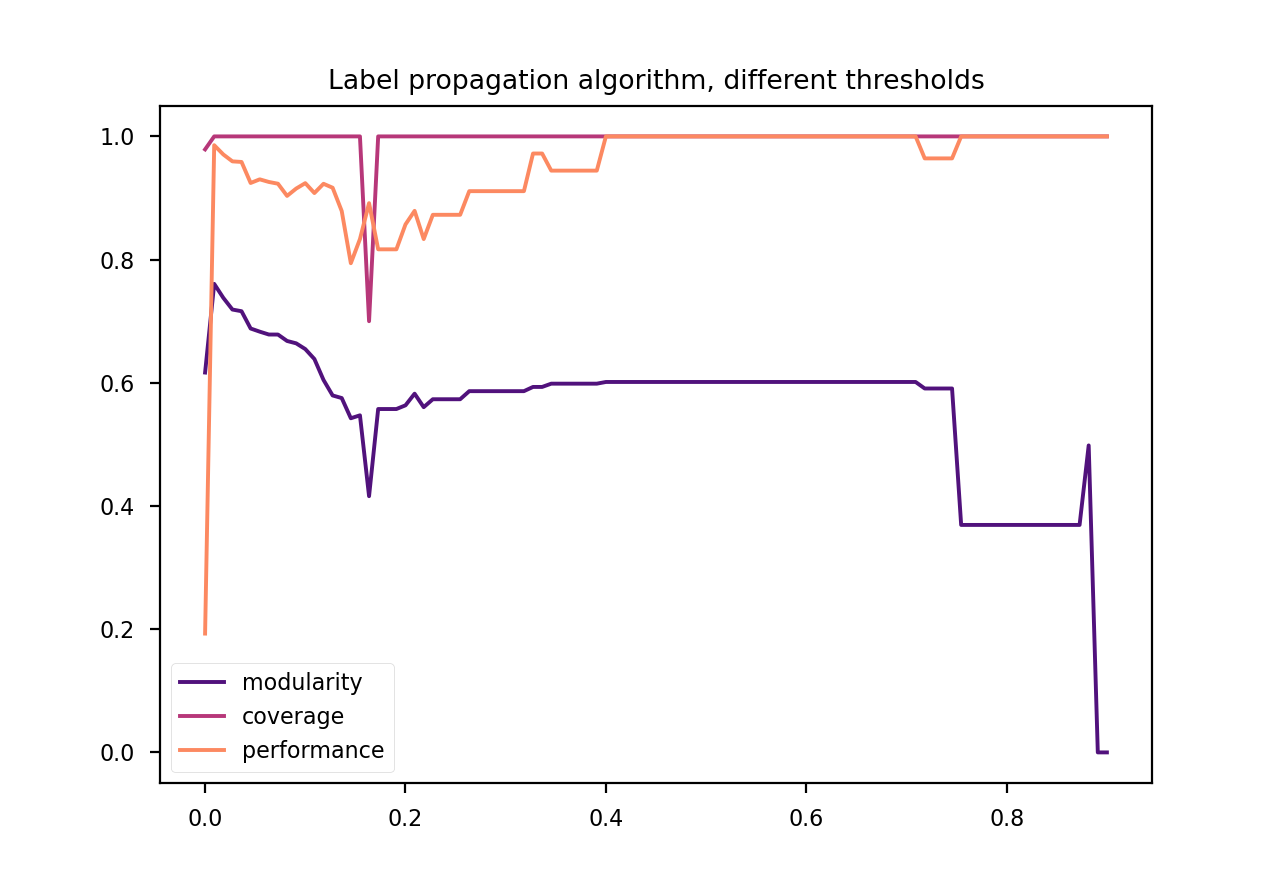

['N:6', 'N:20', 'N:15', 'N:12', 'N:12', 'N:9', 'N:9', 'N:9', 'N:9', 'N:7', 'N:7', 'N:7', 'N:7', 'N:7', 'N:7', 'N:6', 'N:4', 'N:4', 'N:5', 'N:4', 'N:4', 'N:4', 'N:4', 'N:4', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:1', 'N:1']


In [35]:
plt.figure()
colors = sns.color_palette("magma", 3)
plt.plot(thresholds, modularity.values(), label = 'modularity', color = colors[0])
plt.plot(thresholds, coverage.values(), label = 'coverage', color = colors[1])
plt.plot(thresholds, performance.values(), label = 'performance', color = colors[2])
plt.legend()
i = 0
l = []
for v in n_communities.values():
    #plt.annotate('N:'+ str(v), (list(modularity.keys())[i], 0.0))
    l.append('N:'+ str(v))
    i += 1
print(l)
plt.title('Label propagation algorithm, different thresholds')
plt.savefig('../_generated_data/Label propagation, different thresholds', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


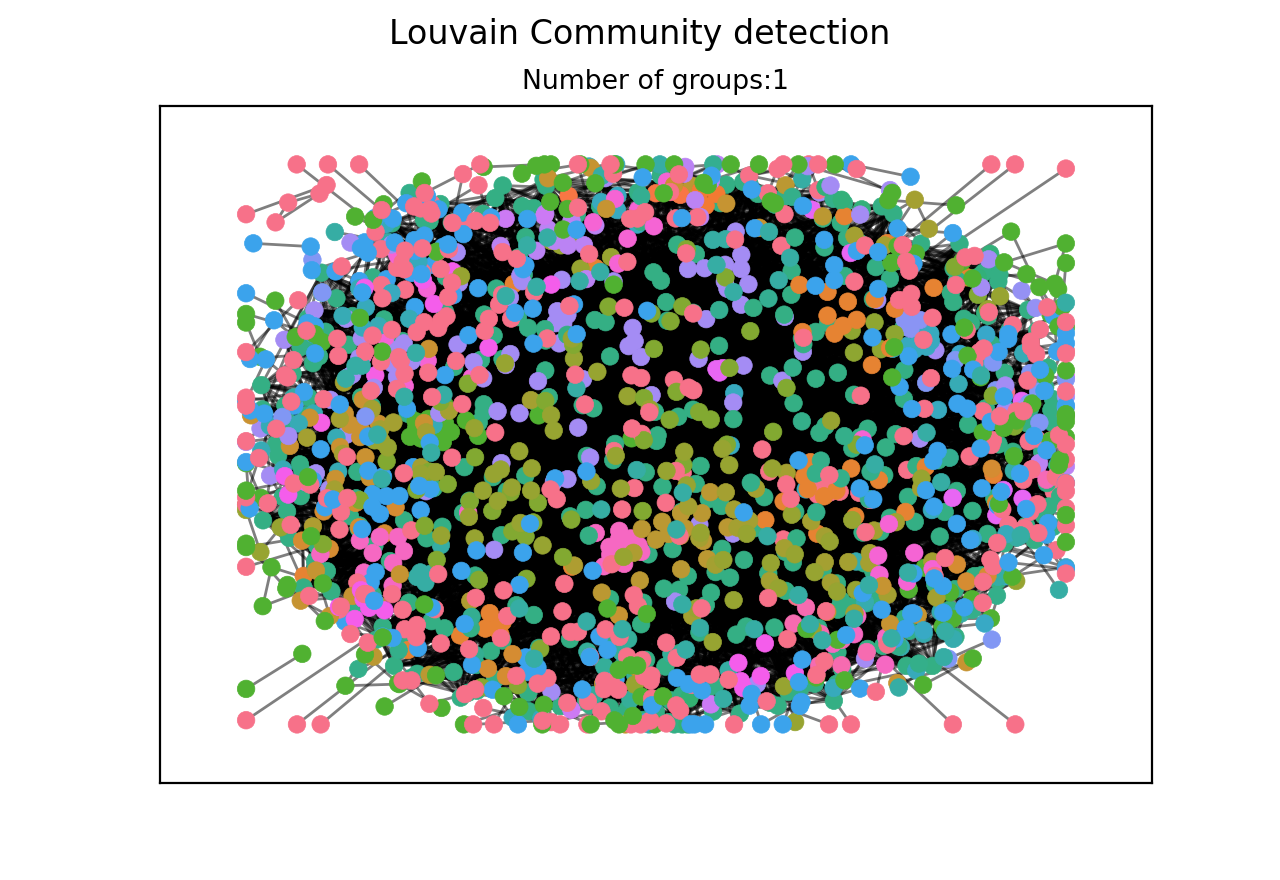

In [36]:
thresholds = np.linspace(0.00002, 0.99, 100)
nets_tt = {}
partitions_tt = {}
algorithm = 'louvain'
for t in thresholds:
    g_tmp = nx.empty_graph()
    g_tmp = network_with_threshold(G, t, False)
    G_louvain, louvain_partition = best_partition(g_tmp, algorithm, False)
    nets_tt[algorithm+str(t)] = G_louvain
    partitions_tt[algorithm+str(t)] = louvain_partition

<IPython.core.display.Javascript object>


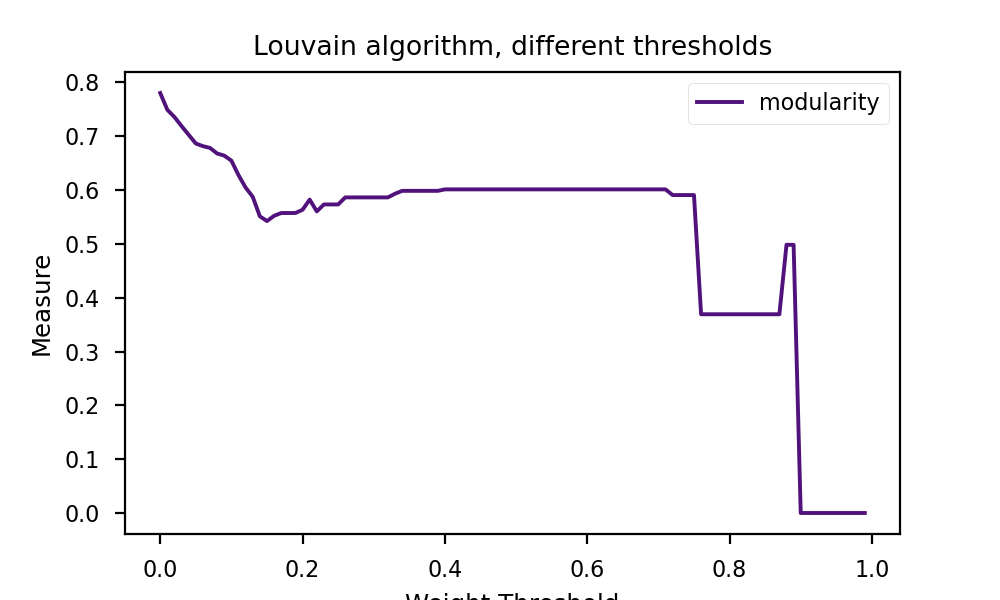

['N:12', 'N:18', 'N:15', 'N:12', 'N:12', 'N:9', 'N:9', 'N:9', 'N:7', 'N:7', 'N:7', 'N:7', 'N:7', 'N:7', 'N:5', 'N:4', 'N:4', 'N:4', 'N:4', 'N:4', 'N:4', 'N:4', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:3', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:2', 'N:1', 'N:1', 'N:1', 'N:1', 'N:1', 'N:1', 'N:1', 'N:1', 'N:1', 'N:1']


In [73]:
modularity = {}
coverage = {}
performance = {}
n_communities = {}
t1 = 0.0005
t2 = 0.005
t3 = 0.015
#The performance of a partition is the number of intra-community edges plus inter-community 
#non-edges divided by the total number of potential edges.
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.performance.html#networkx.algorithms.community.quality.performance
for algorithm, partition in partitions_tt.items():
    p = dic_to_partition(partition)
    coverage[algorithm] = community.quality.coverage(nets_tt[algorithm], p)
    performance[algorithm] = community.quality.partition_quality(nets_tt[algorithm], p)[1]
    modularity[algorithm] = community.quality.modularity(nets_tt[algorithm], p)
    n_communities[algorithm] = len(set(partitions_tt[algorithm].values()))
plt.figure(figsize=(5,3))
colors = sns.color_palette("magma", 3)
plt.plot(thresholds, modularity.values(), label = 'modularity', color = colors[0])
#plt.plot(thresholds, coverage.values(), label = 'coverage', color = colors[1])
#plt.plot(thresholds, performance.values(), label = 'performance', color = colors[2])
plt.legend()
l = []
i = 0
for v in n_communities.values():
    #plt.annotate('N:'+ str(v), (list(modularity.keys())[i], 0.0))
    l.append('N:'+ str(v))
    i += 1
print(l)
plt.title('Louvain algorithm, different thresholds')
plt.savefig('../_generated_data/Louvain, different thresholds1', dpi=600)
#plt.vlines(0.92, 0, 1, colors='red', linestyles='solid',)
#plt.vlines(t1, 0, 1, colors='#EC7063', 
#           label = 't={}'.format(t1), linestyles='solid')
#plt.vlines(t2, 0, 1, colors='#F39C12', label = 't={}'.format(t2),
#           linestyles='solid')
#plt.vlines(t3, 0, 1, colors='#A569BD', label = 't={}'.format(t3),
#           linestyles='solid')
plt.xlabel('Weight Threshold')
plt.ylabel('Measure')
plt.legend()#loc='right')
plt.show()

<IPython.core.display.Javascript object>


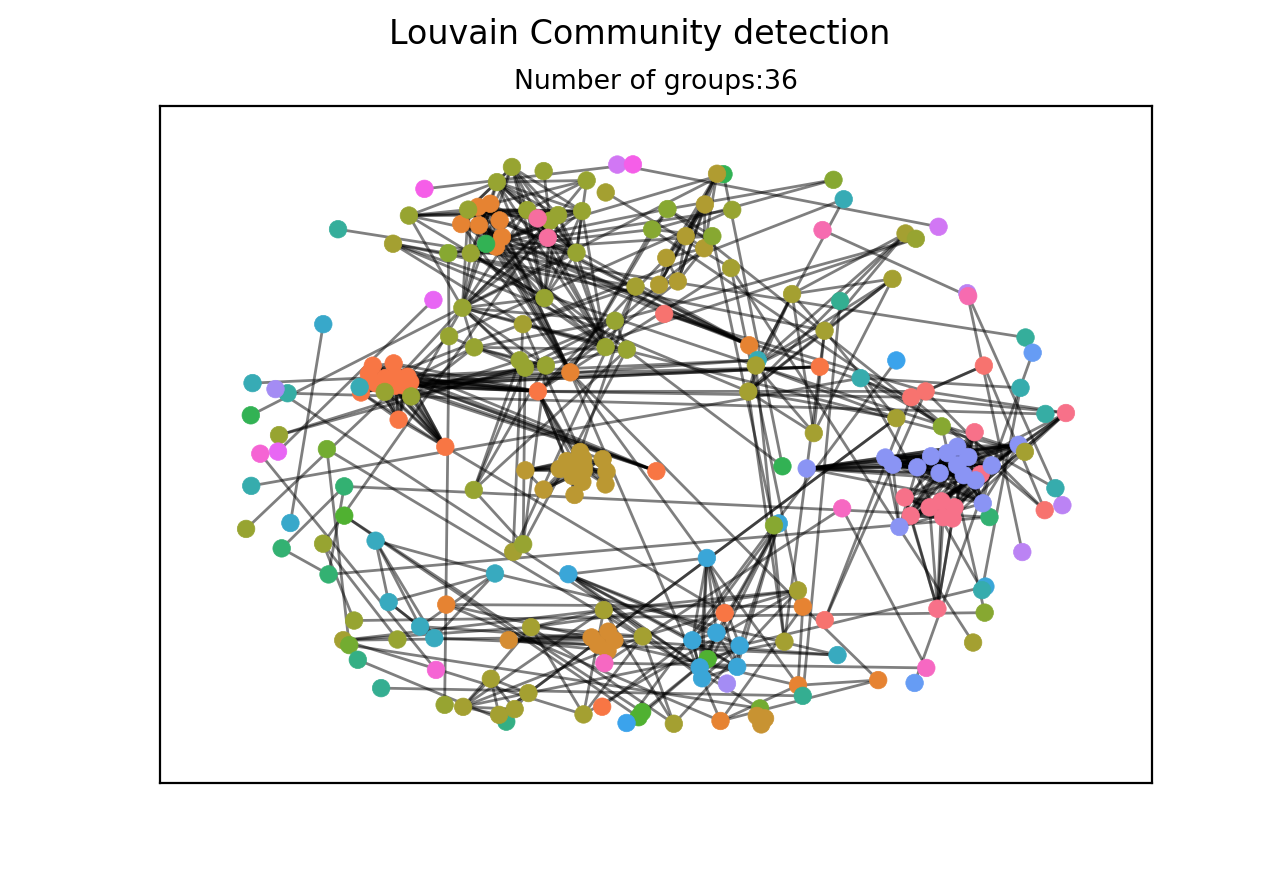

  0%|          | 0/741 [00:00<?, ?it/s]

In [99]:
'''Selected Net, using threshold weight = 0.0005 and Louvain algorithm'''
algorithm = 'louvain'
g = nx.empty_graph()
g = network_with_threshold(G, 0.0005, False)
t_01, p_01 = best_partition(g, algorithm)
plt.show()
add_similarity_attr(t_01)
add_correlation_attr(t_01)
nx.write_gpickle(t_01, "../_generated_data/Net_1v3.gpickle")

<IPython.core.display.Javascript object>


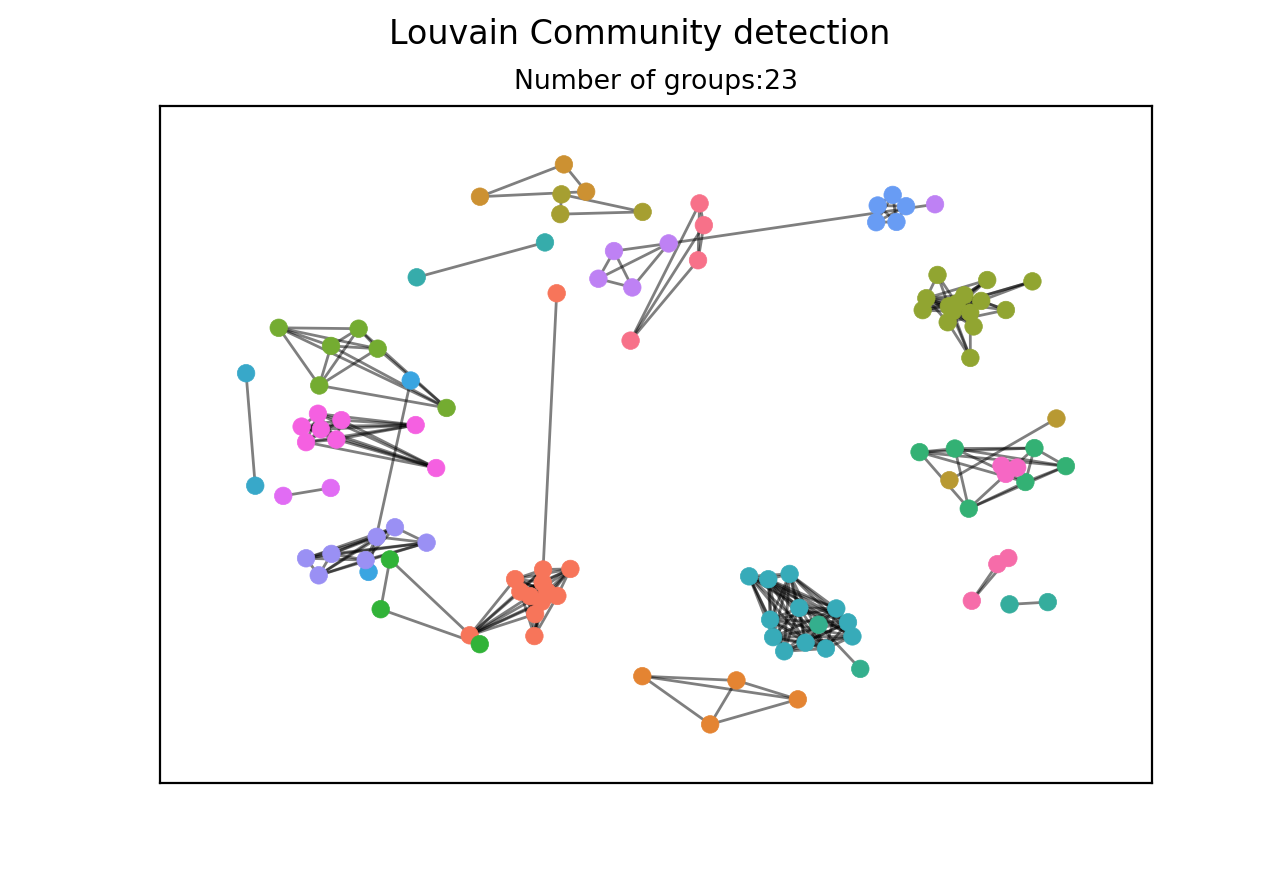

  0%|          | 0/311 [00:00<?, ?it/s]

In [100]:
'''Selected Net, using threshold weight = 0.005 and Louvain algorithm'''
algorithm = 'louvain'
g = nx.empty_graph()
g = network_with_threshold(G, 0.005, False)
t_02, p_02 = best_partition(g, algorithm)
plt.show()
add_similarity_attr(t_02)
add_correlation_attr(t_02)
nx.write_gpickle(t_02, "../_generated_data/Net_2v3.gpickle")

<IPython.core.display.Javascript object>


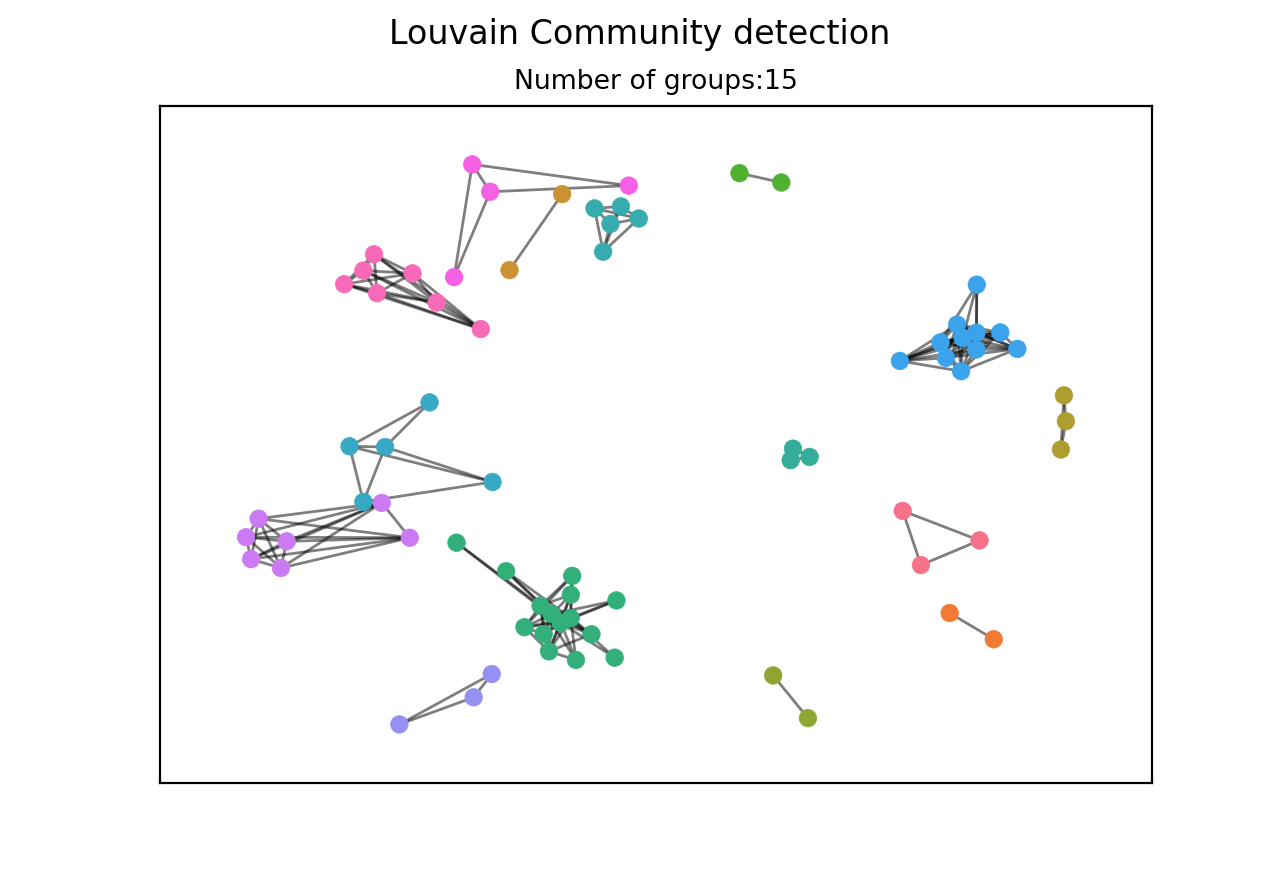

  0%|          | 0/178 [00:00<?, ?it/s]

In [101]:
'''Selected Net, using threshold weight = 0.005 and Louvain algorithm'''
algorithm = 'louvain'
g = nx.empty_graph()
g = network_with_threshold(G, 0.015, False)
t_03, p_03 = best_partition(g, algorithm)
add_similarity_attr(t_03)
add_correlation_attr(t_03)
nx.write_gpickle(t_03, "../_generated_data/Net_3v3.gpickle")

# Compare algorithms with defined thresholds

In [76]:
'''threshold weight = 0.0003 all the algorithms. Label k=3 by default'''
algorithms = ['louvain','label','girvan_newman']
partitions_01 = {}
for a in algorithms:
    g = nx.empty_graph()
    g = network_with_threshold(G, 0.015, False)
    t_01, p_01 = best_partition(g, a)
    partitions_01[a] = p_01

In [58]:
df_t01 = generate_df_nmi_ars_partitions(g, partitions_01)

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


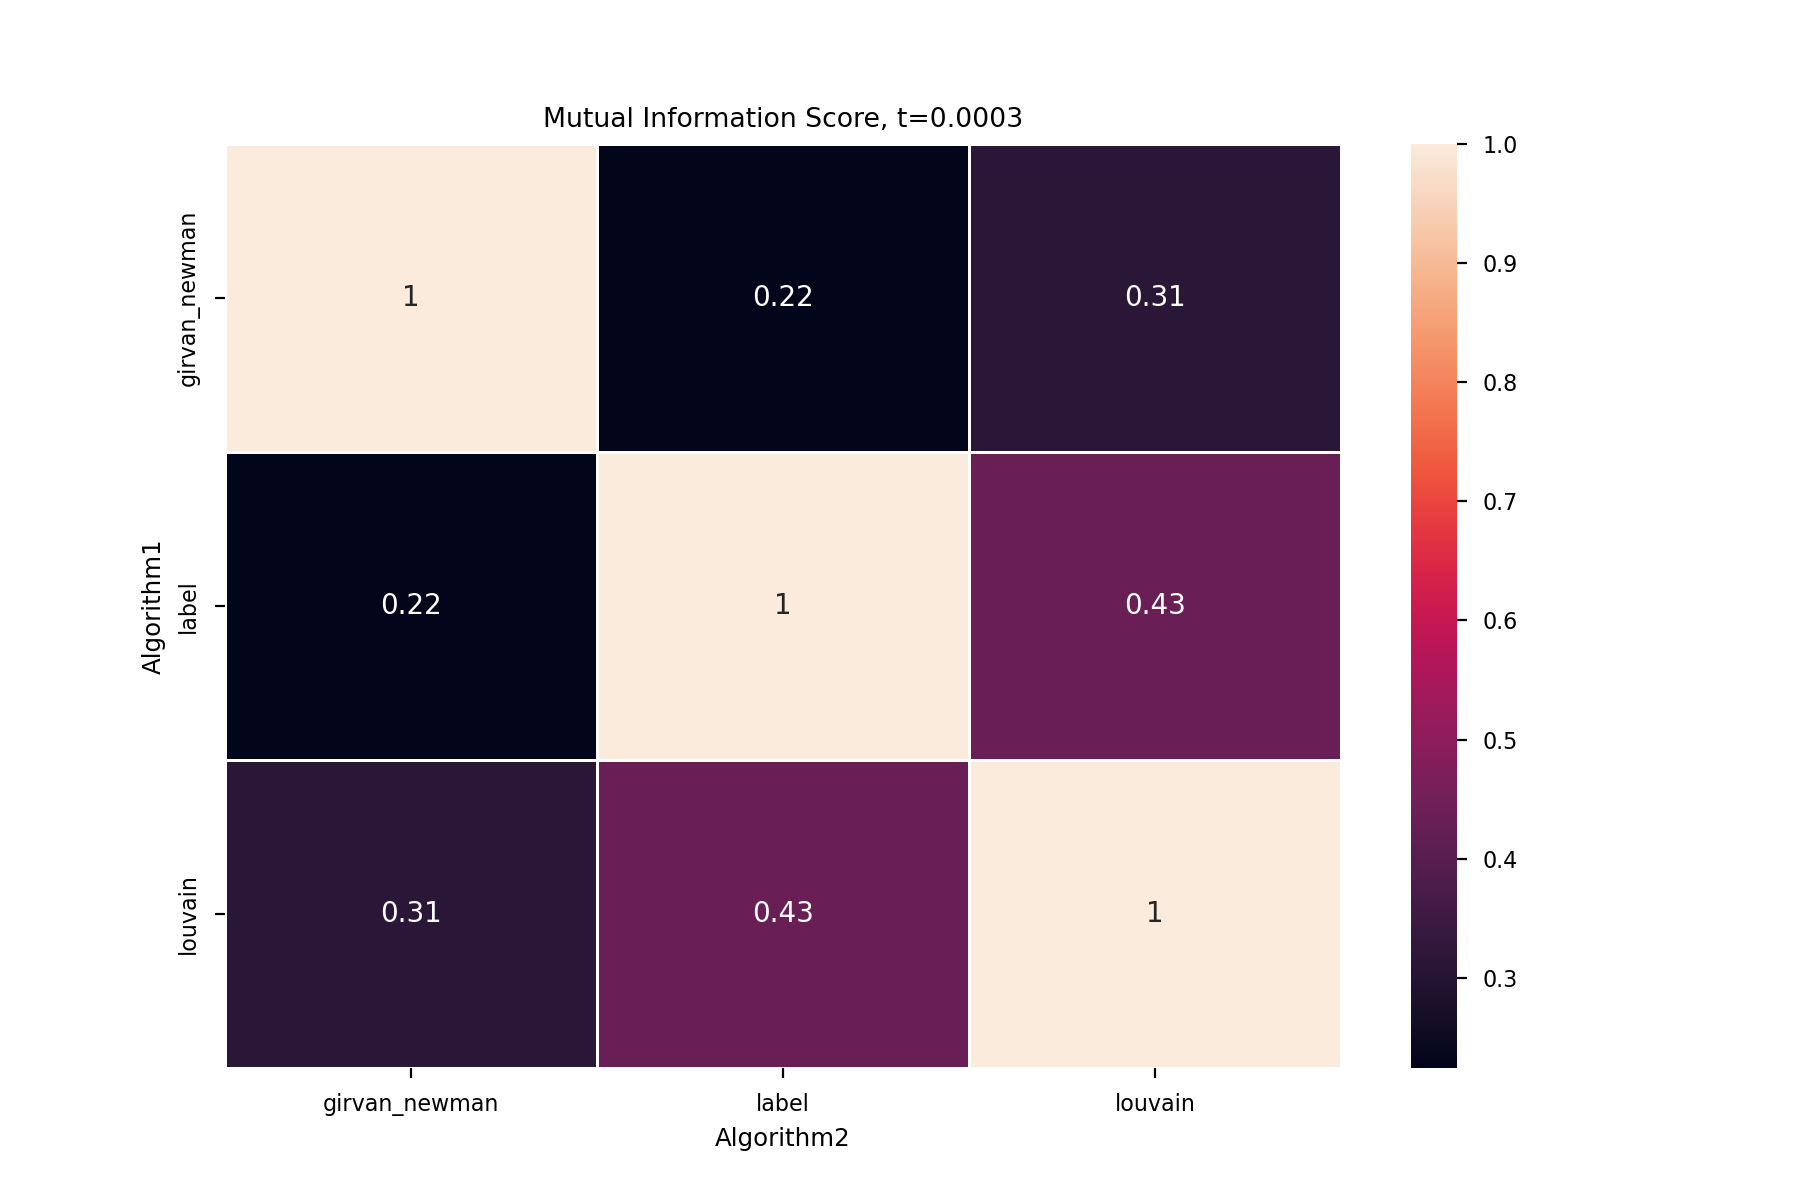

In [64]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_t01, annot=True, linewidths=.5, ax=ax)
plt.title('Mutual Information Score, t=0.0003')
plt.show()

In [65]:
'''threshold weight = 0.0009 all the algorithms. Label k=3 by default'''
algorithms = ['louvain','label','girvan_newman']
partitions_02 = {}
for a in algorithms:
    g = nx.empty_graph()
    g = network_with_threshold(G, 0.0009, False)
    t_02, p_02 = best_partition(g, a)
    partitions_02[a] = p_02

In [66]:
df_t02 = generate_df_nmi_ars_partitions(g, partitions_02)

  0%|          | 0/3 [00:00<?, ?it/s]

In [67]:
df_t02.head()

Algorithm2     girvan_newman     label   louvain
Algorithm1                                      
girvan_newman       1.000000  0.257105  0.174573
label               0.257105  1.000000  0.509949
louvain             0.174573  0.509949  1.000000

<IPython.core.display.Javascript object>


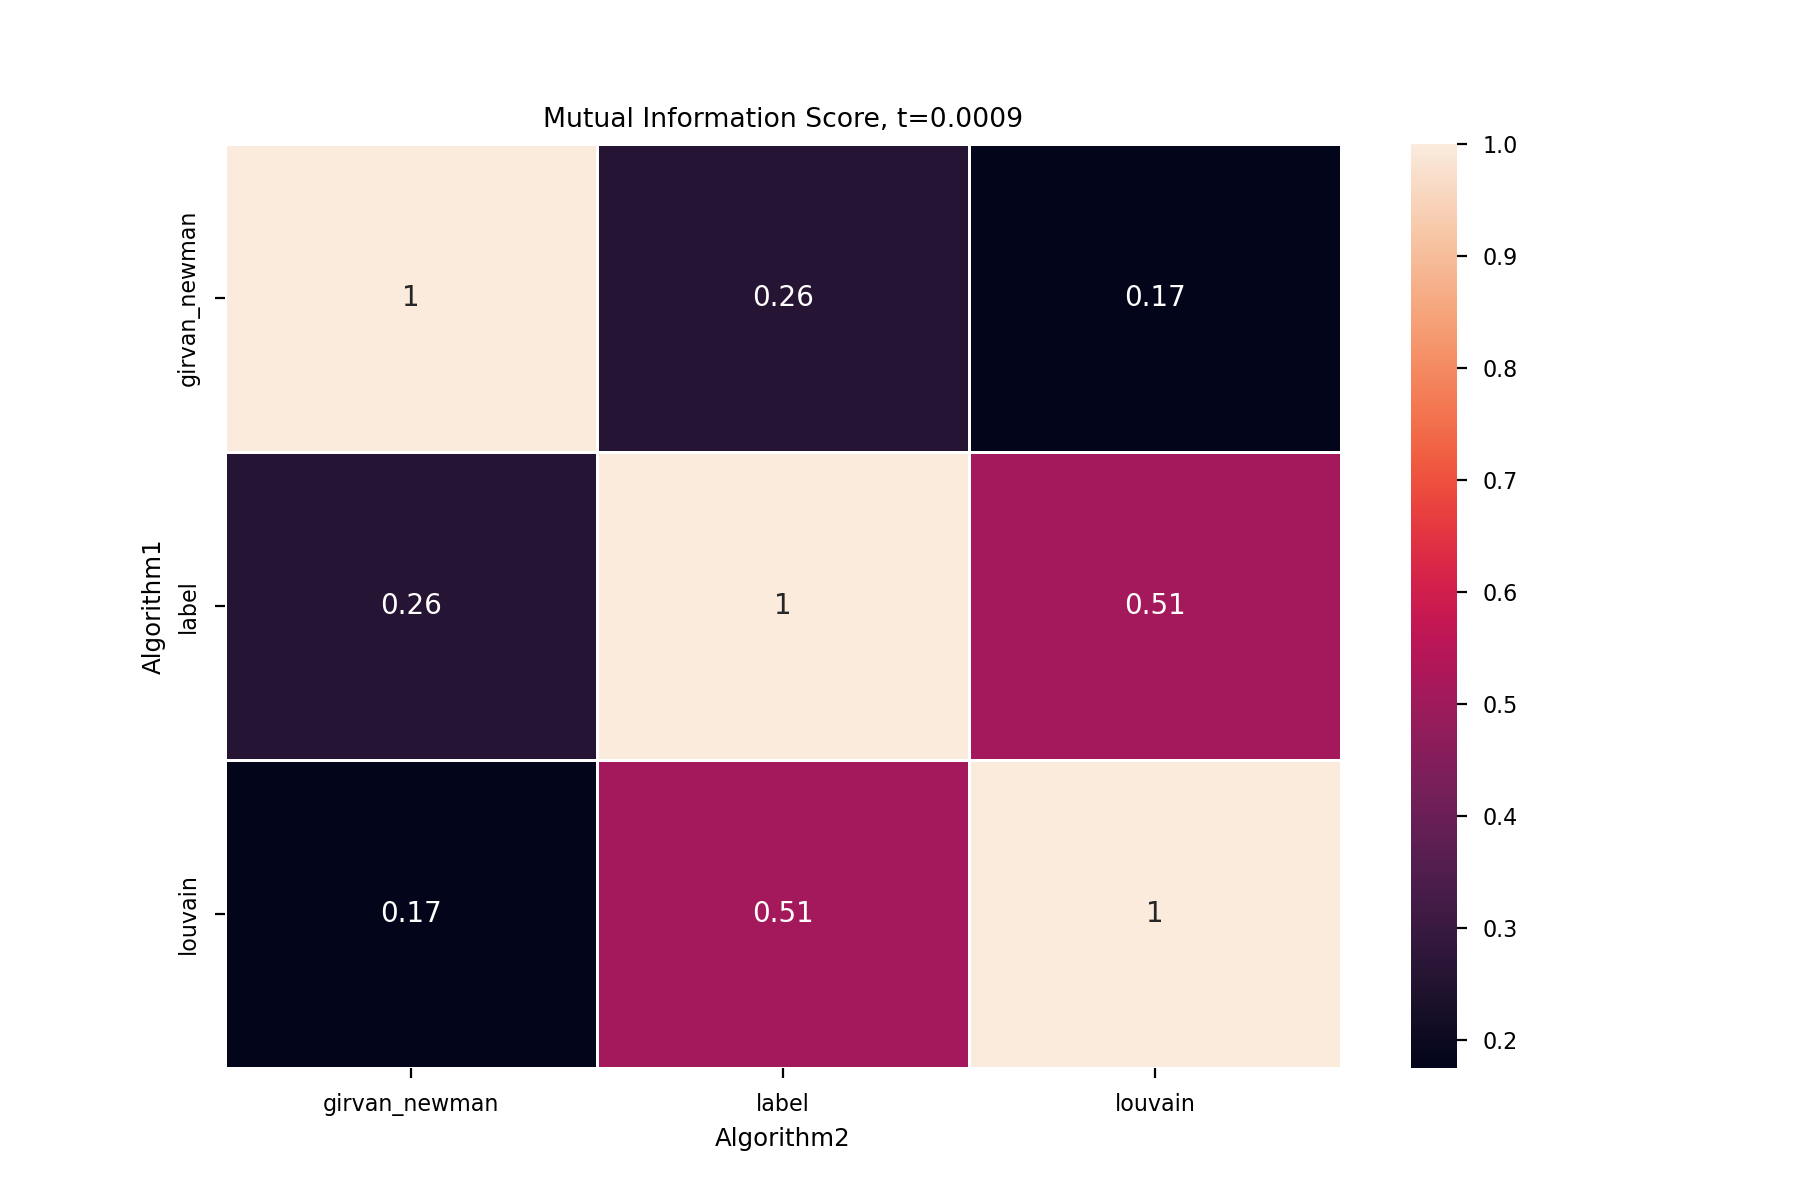

In [68]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_t02, annot=True, linewidths=.5, ax=ax)
plt.title('Mutual Information Score, t=0.0009')
plt.show()

In [69]:
'''threshold weight = 0.0012 all the algorithms. Label k=3 by default'''
algorithms = ['louvain','label','girvan_newman']
partitions_03 = {}
for a in algorithms:
    g = nx.empty_graph()
    g = network_with_threshold(G, 0.0012, False)
    t_03, p_03 = best_partition(g, a)
    plt.show()
    partitions_03[a] = p_03

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


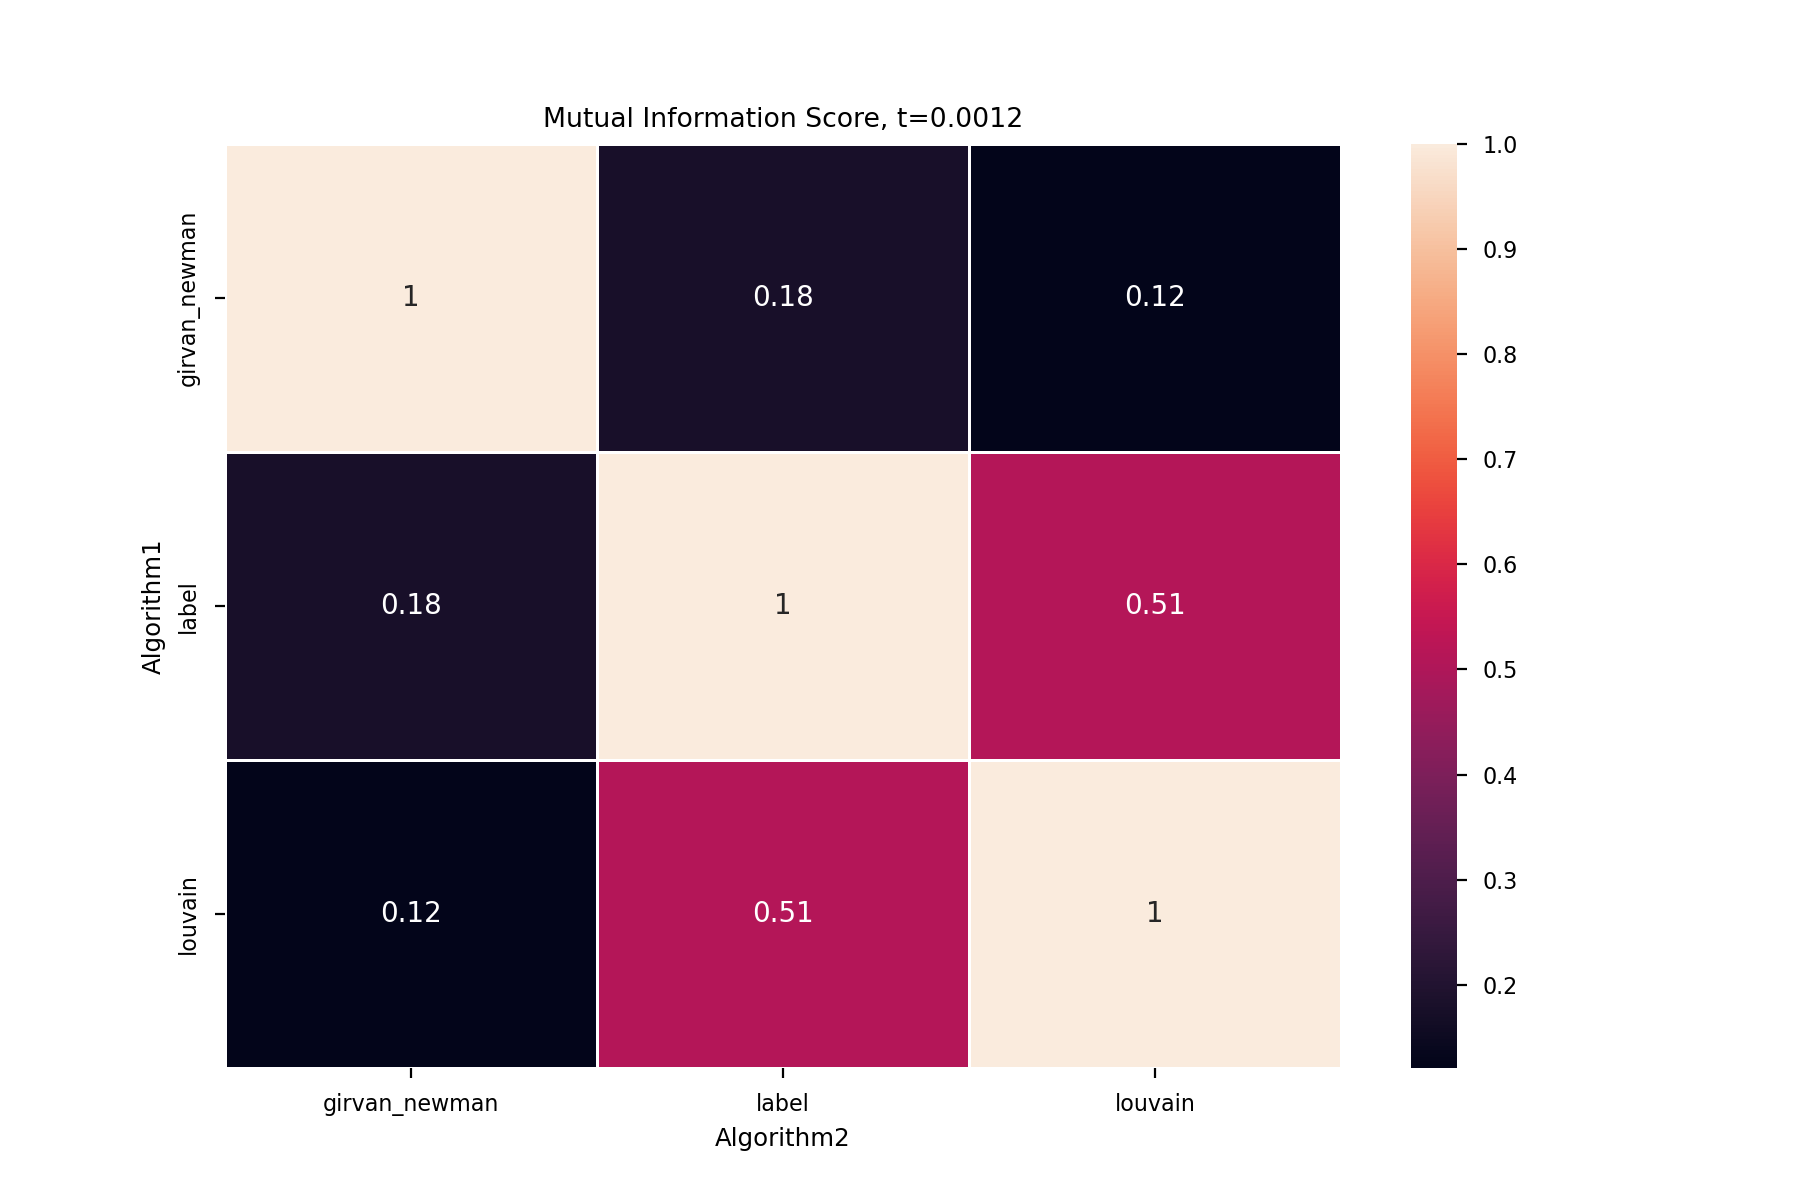

In [70]:
df_t03 = generate_df_nmi_ars_partitions(g, partitions_03)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_t03, annot=True, linewidths=.5, ax=ax)
plt.title('Mutual Information Score, t=0.0012')
plt.show()

In [71]:
def find_hashtag_community(hashtag, algorithm):
    p = partitions[algorithm]
    #print(p)
    com = p[hashtag]
    return dic_to_partition(p)[com]

In [72]:
for algorithm, net in nets.items():
    add_similarity_attr(net)
    add_correlation_attr(net)
    nx.write_gpickle(G, "../_generated_data/Net_"+algorithm+"v3.gpickle")

  0%|          | 0/19179 [00:00<?, ?it/s]

  0%|          | 0/19179 [00:00<?, ?it/s]

  0%|          | 0/19179 [00:00<?, ?it/s]

# Plot different thresholds

<IPython.core.display.Javascript object>


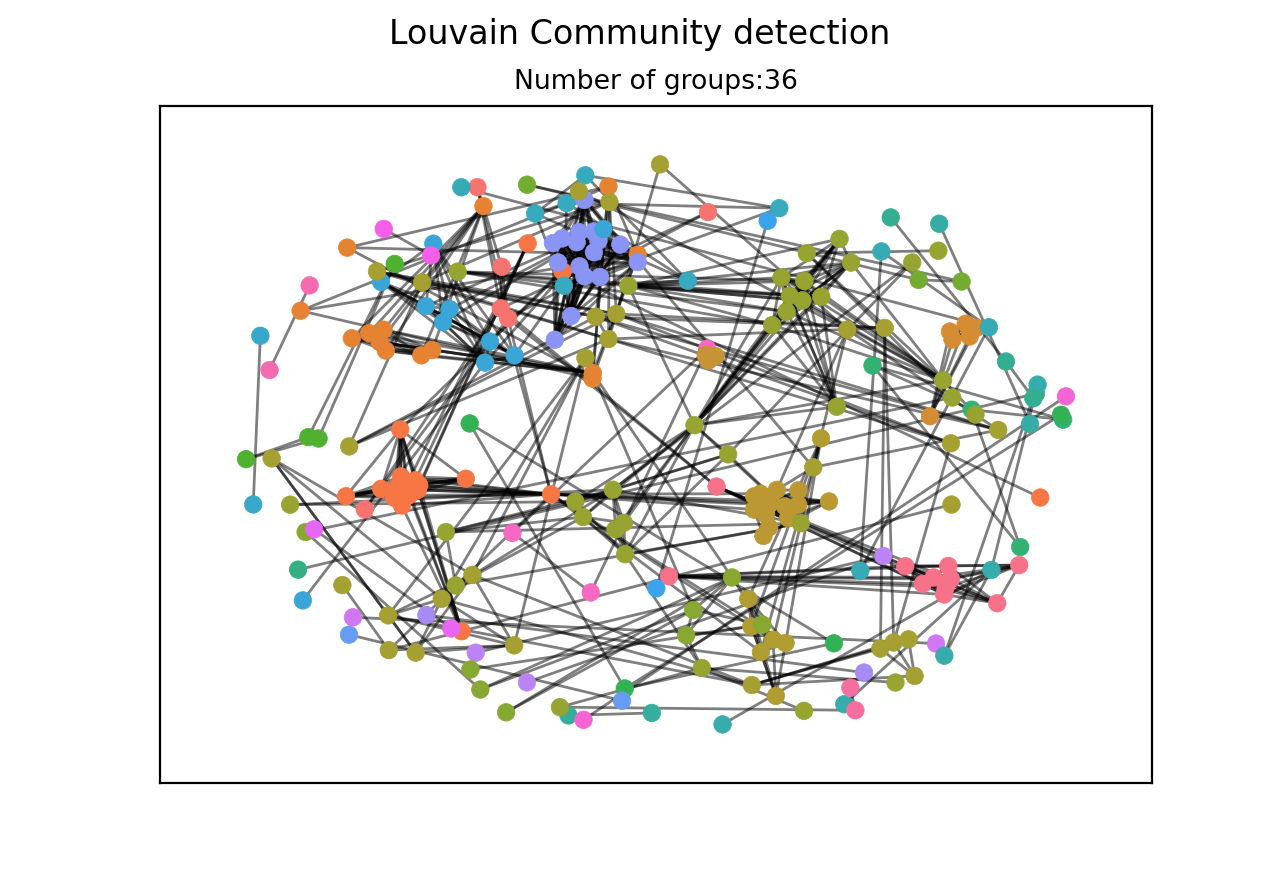

  0%|          | 0/741 [00:00<?, ?it/s]

In [106]:
%matplotlib notebook
import matplotlib.pyplot as plt
algorithm = 'louvain'
g_01 = nx.empty_graph()
g_01 = network_with_threshold(G, 0.0005, False)
g_01, g_01_partition = best_partition(g_01, algorithm, True)
plt.show()
add_similarity_attr(g_01)
add_correlation_attr(g_01)

<IPython.core.display.Javascript object>


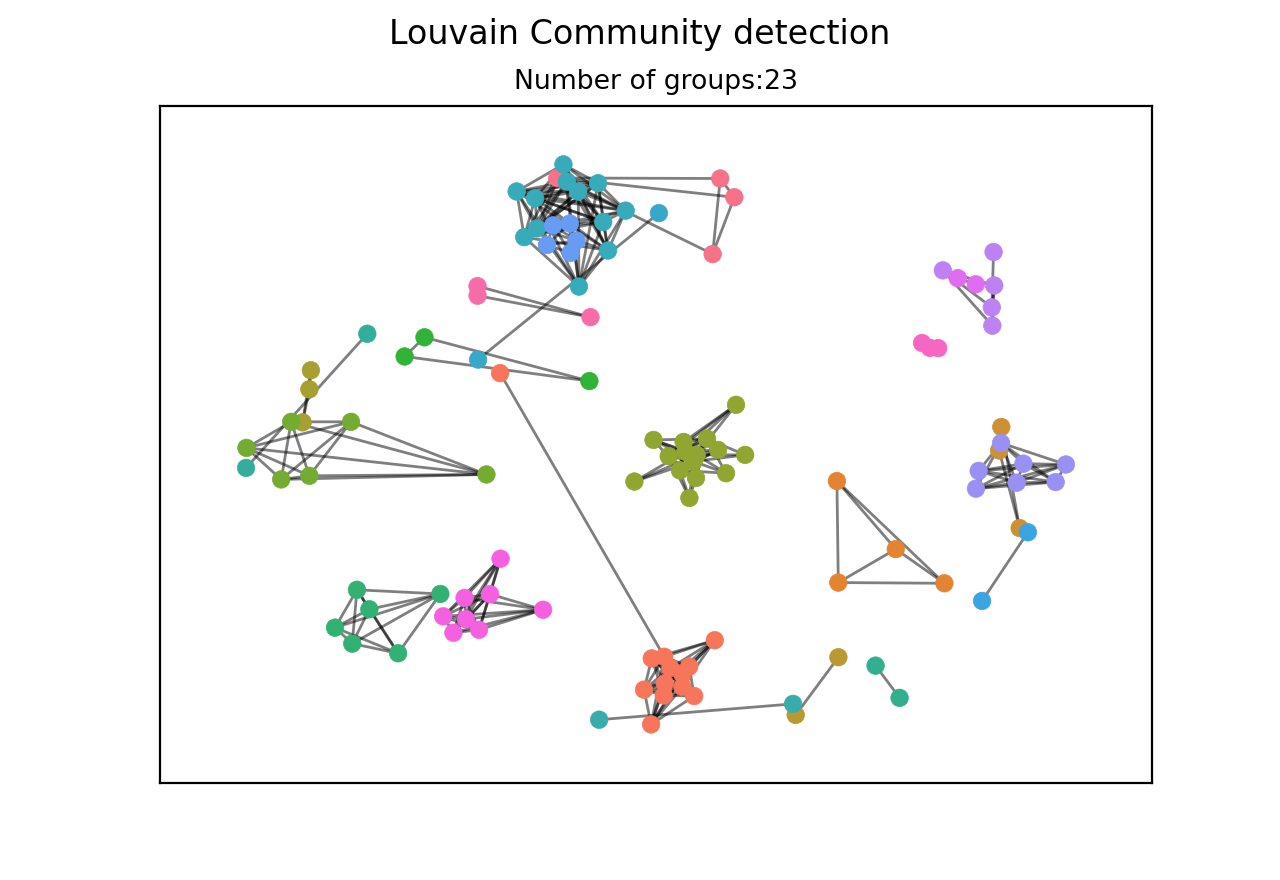

  0%|          | 0/311 [00:00<?, ?it/s]

In [107]:
algorithm = 'louvain'
g_02 = nx.empty_graph()
g_02 = network_with_threshold(G, 0.005, False)
g_02, g_02_partition = best_partition(g_02, algorithm, True)
plt.show()
add_similarity_attr(g_02)
add_correlation_attr(g_02)

<IPython.core.display.Javascript object>


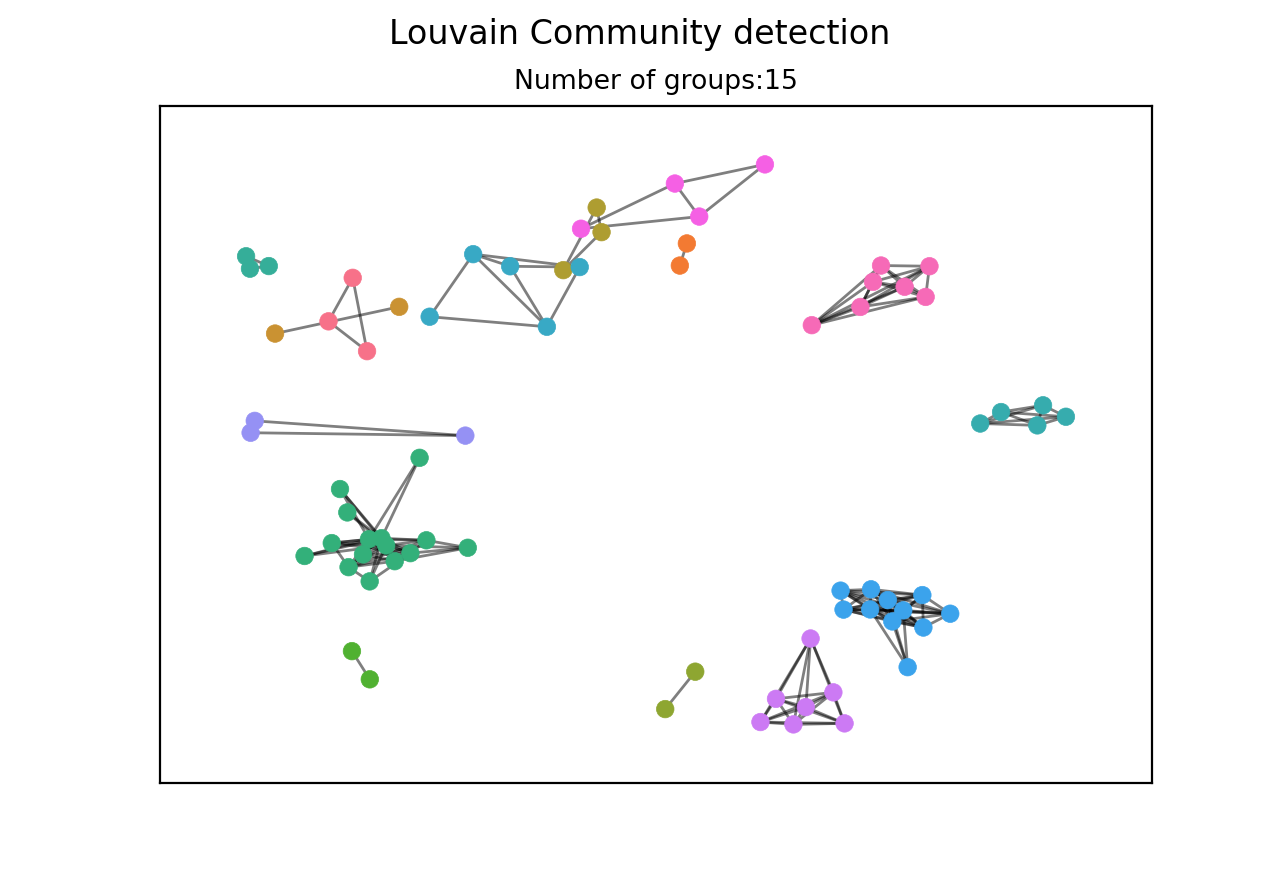

  0%|          | 0/178 [00:00<?, ?it/s]

In [108]:
algorithm = 'louvain'
g_03 = nx.empty_graph()
g_03 = network_with_threshold(G, 0.015, False)
g_03, g_03_partition = best_partition(g_03, algorithm, True)
plt.show()
add_similarity_attr(g_03)
add_correlation_attr(g_03)

<IPython.core.display.Javascript object>


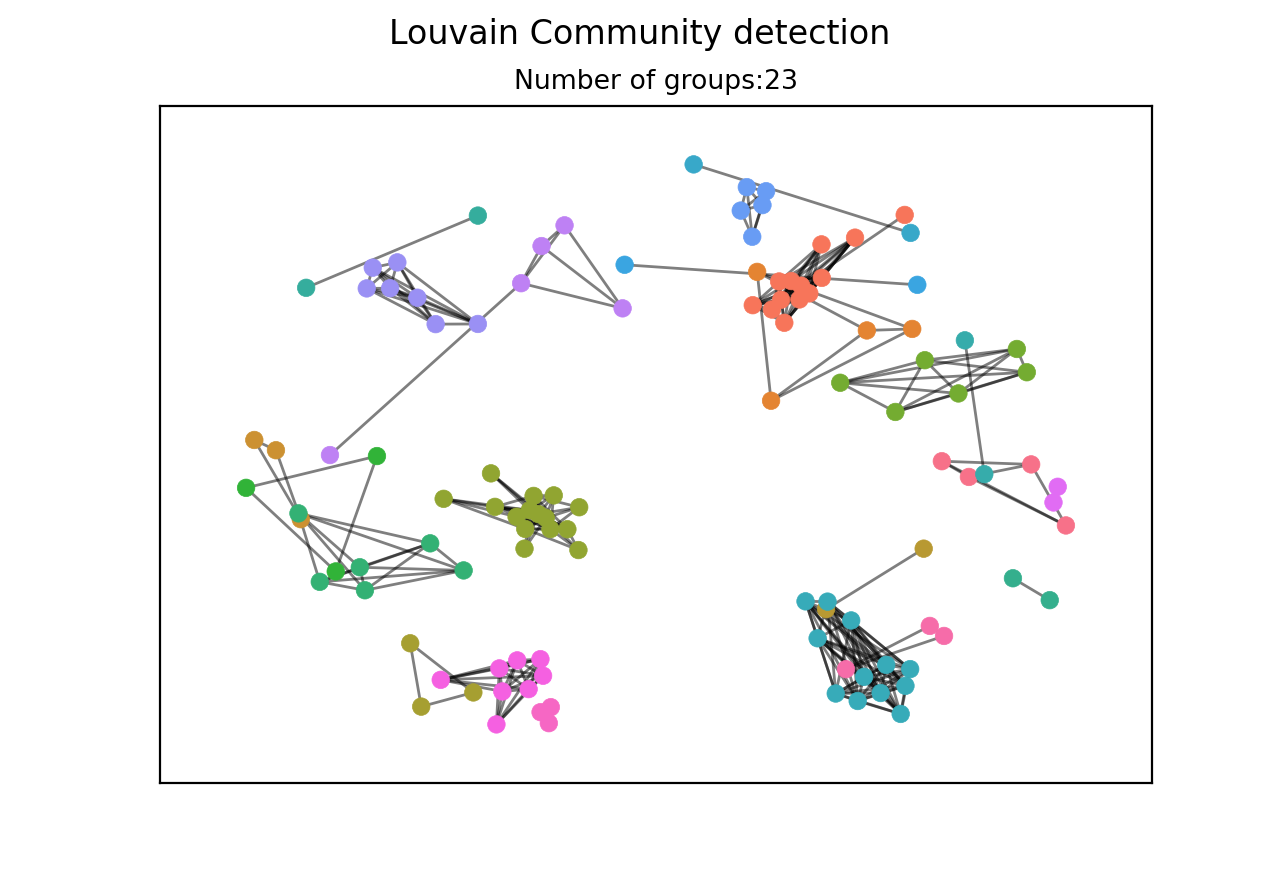

  0%|          | 0/311 [00:00<?, ?it/s]

In [76]:
algorithm = 'louvain'
g_0 = nx.empty_graph()
g_0 = network_with_threshold(G, 0.005, False)
g_0, g_0_partition = best_partition(g_0, algorithm, True)
plt.show()
add_similarity_attr(g_0)
add_correlation_attr(g_0)

groups_dic =nx.get_node_attributes(g_0,'group')
groups = list(set(groups_dic.values()))
selected_nodes = []
for g in groups:
    list_nodes = [node for node, v in groups_dic.items() if v == g]
    sub_g = g_0.subgraph(list_nodes)
    sorted_nodes = sorted(sub_g.degree, key=lambda x: x[1], reverse=True)
    #print(sorted_nodes)
    i = 0
    for node, degree in sorted_nodes:
        if i == 5:
            break
        selected_nodes.append(node)
        i += 1

In [77]:
print(len(g_0.edges()))
print(len(selected_nodes)) 

311
82


In [78]:
g_0.number_of_nodes() 

114

In [79]:
g_0.remove_nodes_from([n for n in g_0 if n not in set(selected_nodes)])
print(g_0.number_of_nodes())
print(g_0.number_of_edges()) #2601

82
121


<IPython.core.display.Javascript object>


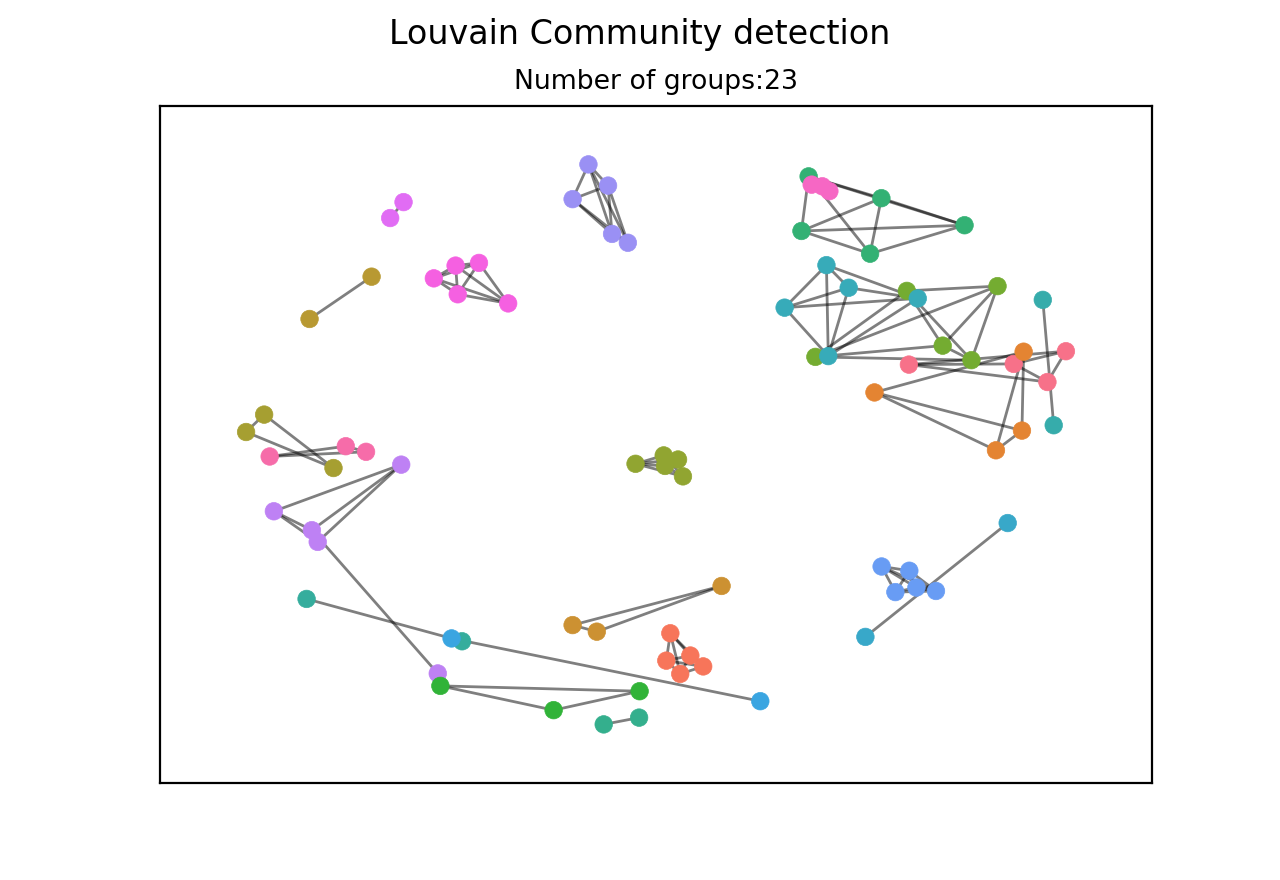

In [80]:
pos = nx.spring_layout(g_0)
nx.draw_networkx_nodes(g_0, pos, node_size=40,
                       node_color = list(nx.get_node_attributes(g_0,'color').values()),
                       label=list(g_01.nodes()))
nx.draw_networkx_edges(g_0, pos, alpha=0.5)
plt.suptitle('Louvain Community detection')
plt.title('Number of groups:' + str(len(list(set(groups_dic.values())))))
plt.savefig('Louvain Community detection Selected nodes', dpi=300)
nx.write_gpickle(g_0, "Net_Louvain_top5v1.gpickle")

In [110]:
dict(sorted(g_03_partition.items(), key=lambda item: item[1]))

{'coronaviruspandemic': 0,
 'sequester': 0,
 'abandoned': 0,
 'SocialDistance': 1,
 'GMNuStudio': 1,
 'JamminJo': 2,
 'JoAnnBush': 2,
 'Featured': 3,
 'NEWS': 3,
 'India': 3,
 'Entertainment': 4,
 'Bollywood': 4,
 'Corona': 5,
 'LAtraffic': 5,
 'Coronavirus': 6,
 'MayThe4thBeWithYou': 6,
 'faceshield': 6,
 'SaveTheWorld': 6,
 'BillionShieldsChallenge': 6,
 'ExOWorldNow': 6,
 'BillionShields': 6,
 'Bottles2Shields': 6,
 'Masks4All': 6,
 'TogetherAtHome': 6,
 'Covid': 6,
 'BeatThePandemic': 6,
 'earthday': 6,
 'mit': 6,
 'LOCKDOWN2020': 6,
 'support81worldwide': 7,
 'support81longisland': 7,
 'support81newyorkcity': 7,
 'iosgames': 8,
 'transformers': 8,
 'angrybirdstransformers': 8,
 'angrybirds': 8,
 'decepticons': 8,
 'thisis51': 9,
 'db365': 9,
 '30daysofmovement': 9,
 'sweatyselfie': 9,
 'PAUSElifeNYC': 9,
 'bw': 10,
 'bnw': 10,
 'cityscape': 10,
 'lensculture': 10,
 'streetphotographer': 10,
 'urbanstreetphotogallery': 10,
 'photodocumentary': 10,
 'ig_street': 10,
 'urbanstreetpho

In [82]:
g_03_partition

{'covid_19': 0,
 'streetphotographer': 0,
 'urbanstreetphotogallery': 0,
 'photodocumentary': 0,
 'ig_street': 0,
 'urbanstreetphotography': 0,
 'spicollective': 0,
 'w8time': 0,
 'covid19': 0,
 'BillionShieldsChallenge': 1,
 'Coronavirus': 1,
 'MayThe4thBeWithYou': 1,
 'faceshield': 1,
 'SaveTheWorld': 1,
 'ExOWorldNow': 1,
 'BillionShields': 1,
 'Bottles2Shields': 1,
 'Masks4All': 1,
 'TogetherAtHome': 1,
 'earthday': 1,
 'mit': 1,
 'LOCKDOWN2020': 1,
 'hiphop': 2,
 'lilbaby': 2,
 'lilwayne': 2,
 'kjmg': 2,
 'growinsilence': 2,
 'mindonamillion': 2,
 'yourpage': 2,
 'trending': 2,
 'viralvideos': 2,
 'Virus': 3,
 'K': 3,
 'workfromhome': 4,
 'financialprofessional': 4,
 'supersinghs': 4,
 'Covid': 1,
 'Covid19': 5,
 'Google': 5,
 'Featured': 5,
 'NEWS': 5,
 'India': 5,
 'Entertainment': 5,
 'Bollywood': 5,
 'flattenthecurve': 7,
 'dailywalk': 7,
 'itsbetteroutside': 7,
 'motherdaughtertime': 7,
 'masks': 8,
 'sequester': 8,
 'abandoned': 8,
 'doingmypart': 9,
 'coronavirüsü': 9,
 'we

In [121]:
g_03.nodes['Coronavirus']

{'group': 6,
 'color': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336)}

In [86]:
g_01 = network_with_threshold(G, 0.0005, False)
degree_sequence_g_01 = sorted([(d, n) for n, d in g_01.degree()], reverse=True)

In [88]:
g_02 = network_with_threshold(G, 0.005, False)
degree_sequence_g_02 = sorted([(d, n) for n, d in g_02.degree()], reverse=True)

In [89]:
g_03 = network_with_threshold(G, 0.015, False)
degree_sequence_g_03 = sorted([(d, n) for n, d in g_03.degree()], reverse=True)

In [105]:
degree_sequence_g_03[:45]

[(13, 'SaveTheWorld'),
 (13, 'BillionShields'),
 (11, 'BillionShieldsChallenge'),
 (10, 'urbanstreetphotography'),
 (10, 'urbanstreetphotogallery'),
 (10, 'photodocumentary'),
 (10, 'ig_street'),
 (10, 'Bottles2Shields'),
 (9, 'streetphotographer'),
 (9, 'spicollective'),
 (9, 'lensculture'),
 (9, 'bw'),
 (9, 'Coronavirus'),
 (8, 'cityscape'),
 (8, 'bnw'),
 (7, 'faceshield'),
 (6, 'yourpage'),
 (6, 'viralvideos'),
 (6, 'squeegeekid'),
 (6, 'setomas'),
 (6, 'selfpublish'),
 (6, 'mindonamillion'),
 (6, 'lilwayne'),
 (6, 'lilbaby'),
 (6, 'kjmg'),
 (6, 'hamont'),
 (6, 'growinsilence'),
 (6, 'crackiltonOMT'),
 (6, 'crackilton'),
 (6, 'carnystories'),
 (6, 'Masks4All'),
 (6, 'ExOWorldNow'),
 (5, 'MayThe4thBeWithYou'),
 (4, 'transformers'),
 (4, 'thisis51'),
 (4, 'iosgames'),
 (4, 'decepticons'),
 (4, 'db365'),
 (4, 'classicnegative'),
 (4, 'angrybirdstransformers'),
 (4, 'angrybirds'),
 (4, 'TogetherAtHome'),
 (4, 'BeatThePandemic'),
 (3, 'sweatyselfie'),
 (3, 'itsbetteroutside')]

In [102]:
degree_sequence_g_03[:1]

[(13, 'SaveTheWorld')]

<IPython.core.display.Javascript object>


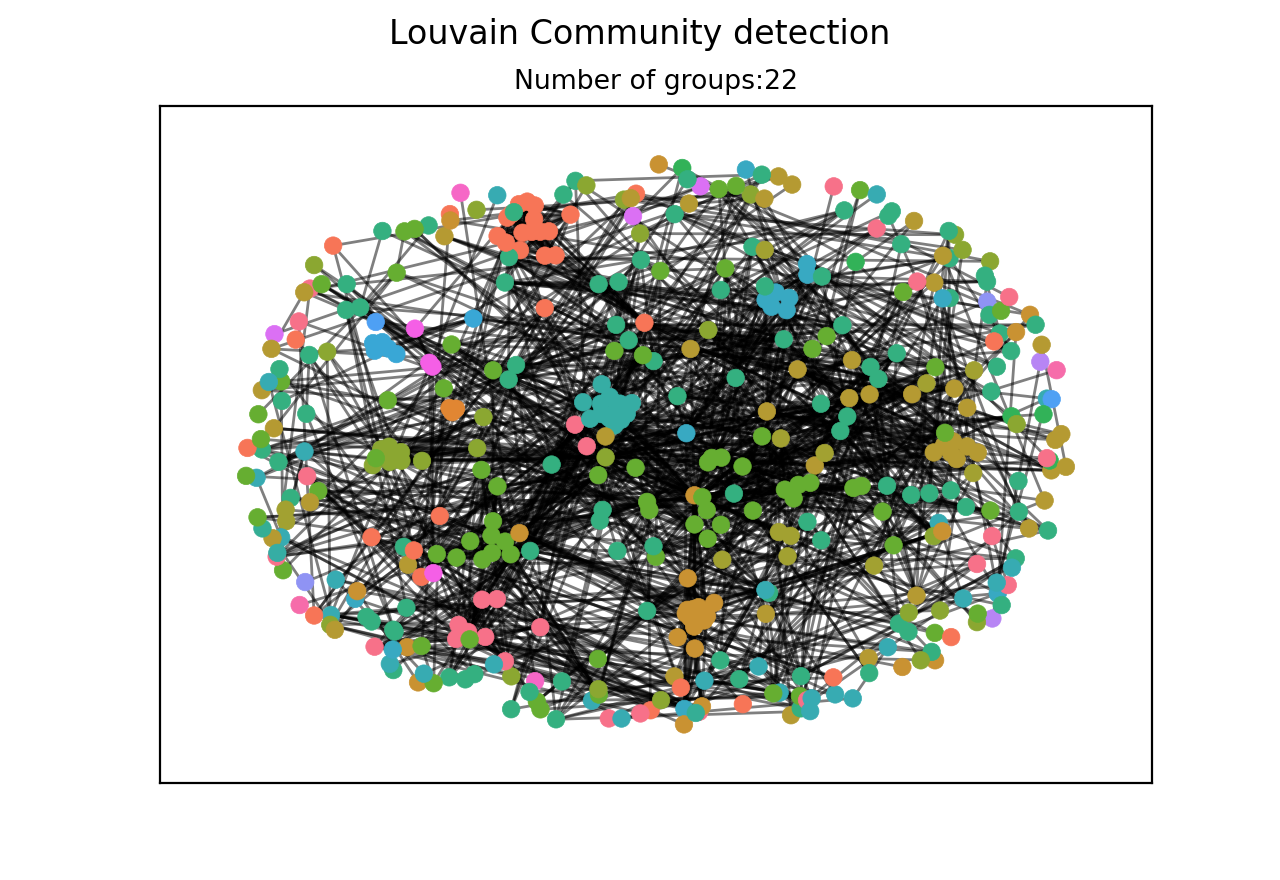

  0%|          | 0/1683 [00:00<?, ?it/s]

In [59]:
algorithm = 'louvain'
g_f = nx.empty_graph()
g_f = network_with_threshold(G, 0.0001, False)
g_f, g_f_partition = best_partition(g_f, algorithm, True)
plt.show()
add_similarity_attr(g_f)
add_correlation_attr(g_f)
nx.write_gpickle(g_f, "../_generated_data/Net_Louvain_full.gpickle")

In [85]:
g_02.nodes(data=True)

NodeDataView({'covid_19': {}, 'urbanstreetphotography': {}, 'Coronavirus': {}, 'MayThe4thBeWithYou': {}, 'faceshield': {}, 'SaveTheWorld': {}, 'BillionShieldsChallenge': {}, 'ExOWorldNow': {}, 'BillionShields': {}, 'Bottles2Shields': {}, 'Masks4All': {}, 'TogetherAtHome': {}, 'mit': {}, 'LOCKDOWN2020': {}, 'trending': {}, 'lilbaby': {}, 'lilwayne': {}, 'kjmg': {}, 'growinsilence': {}, 'mindonamillion': {}, 'yourpage': {}, 'workfromhome': {}, 'financialprofessional': {}, 'supersinghs': {}, 'Covid': {}, 'Covid19': {}, 'Featured': {}, 'NEWS': {}, 'India': {}, 'flattenthecurve': {}, 'itsbetteroutside': {}, 'doingmypart': {}, 'coronavirüsü': {}, 'wewillsurvive': {}, 'cooperiscute': {}, 'Health': {}, 'Entertainment': {}, 'Bollywood': {}, 'bw': {}, 'bnw': {}, 'cityscape': {}, 'lensculture': {}, 'streetphotographer': {}, 'urbanstreetphotogallery': {}, 'acros': {}, 'photodocumentary': {}, 'ig_street': {}, 'spicollective': {}, 'viralvideos': {}, 'beastmode': {}, 'justlikethat': {}, 'coronavirusp